## II. Financial Strategy

All tweets are in UTC, we import data on stocks in UTC time:
- BTC : daily price (open = 00:00 UTC time) -> returns
- BTC : volumes
And we use from our data:
- Daily sentiment 
- Daily volume of tweets
- Daily change in sentiment

In [6]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from datetime import datetime
tqdm.pandas()

In [2]:
import yfinance as yf

# Define the date range for which you want to fetch historical data
start_date = "2016-11-01"
end_date = "2019-11-01"

btcusd = yf.Ticker("BTC-USD").history(start=start_date, end=end_date)
# Print the resulting DataFrame
btcusd.head(100)

/Users/mehdimouden/Desktop/EPFL/IF/MA3/Fin Machine Learning/BTC NLP/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-11-01 00:00:00+00:00,701.336975,736.452026,701.336975,729.793030,130527000,0.0,0.0
2016-11-02 00:00:00+00:00,730.065979,740.828979,722.348999,740.828979,84865200,0.0,0.0
2016-11-03 00:00:00+00:00,742.346008,745.773010,678.156006,688.700012,172808000,0.0,0.0
2016-11-04 00:00:00+00:00,689.124023,706.929993,685.562988,703.234985,99907696,0.0,0.0
2016-11-05 00:00:00+00:00,703.525024,707.510010,697.739014,703.418030,53752300,0.0,0.0
...,...,...,...,...,...,...,...
2017-02-04 00:00:00+00:00,1031.329956,1045.900024,1015.159973,1042.900024,155064000,0.0,0.0
2017-02-05 00:00:00+00:00,1043.520020,1043.630005,1022.369995,1027.339966,114208000,0.0,0.0
2017-02-06 00:00:00+00:00,1028.400024,1044.640015,1028.160034,1038.150024,111762000,0.0,0.0


In [92]:
############################# Extracting Data from Bitcoin #########################################

btc = btcusd[['Close', 'Volume']]
btc.reset_index(inplace=True)
btc['Date'] = pd.to_datetime(btc['Date'])
btc['Date'] = btc['Date'].dt.tz_convert(None)
btc['Log'] = np.log(btc['Close'])
btc['Return']=btc['Log'].diff()
# Rename the columns
btc = btc.rename(columns={'Close': 'Price'})
# Set 'Date' as the index
btc['Timestamp']=btc['Date']
btc.set_index('Timestamp',inplace=True)
# Calculate the squared returns
btc['Return_squared'] = btc['Return'] ** 2
# Compute the rolling 14 days volatility
btc['Vol_2W'] = np.sqrt(btc['Return_squared'].rolling(window=14, min_periods=14).sum())
#Computing lags for Price, Return and Volatility
for lag in range(5):
    btc[f'Price_lag_{lag+1}'] = btc['Price'].shift(lag+1)
btc['Price_lag_7'] = btc['Price'].shift(7)
btc['Price_lag_14'] = btc['Price'].shift(14)
btc['Price_lag_21'] = btc['Price'].shift(21)
btc['Price_lag_28'] = btc['Price'].shift(28)
btc['Vol_2W_lag_1'] = btc['Vol_2W'].shift(1)
for lag in range(2):
    btc[f'Vol_2W_lag_{(lag+1)*14+1}'] = btc['Vol_2W'].shift((lag+1)*14+1)
for lag in range(5):
    btc[f'Return_lag_{lag+1}'] = btc['Return'].shift(lag+1)
    btc[f'Volume_lag_{lag+1}'] = btc['Volume'].shift(lag+1)
btc = btc[btc['Date']>= pd.to_datetime('2016-12-01')]
btc.head(30)

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_90984/1330279255.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Date'] = pd.to_datetime(btc['Date'])
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_90984/1330279255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Date'] = btc['Date'].dt.tz_convert(None)
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_90984/1330279255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,Date,Price,Volume,Log,Return,Return_squared,Vol_2W,Price_lag_1,Price_lag_2,Price_lag_3,...,Return_lag_1,Volume_lag_1,Return_lag_2,Volume_lag_2,Return_lag_3,Volume_lag_3,Return_lag_4,Volume_lag_4,Return_lag_5,Volume_lag_5
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-12-01,2016-12-01,756.773987,80461904,6.629065,0.014753,2.176619e-04,0.044758,745.690979,735.604004,735.812988,...,0.013619,84070800.0,-0.000284,68511104.0,0.005148,61888600.0,-0.004562,52601800.0,-0.008486,54962700.0
2016-12-02,2016-12-02,777.943970,127605000,6.656655,0.027590,7.612003e-04,0.050620,756.773987,745.690979,735.604004,...,0.014753,80461904.0,0.013619,84070800.0,-0.000284,68511104.0,0.005148,61888600.0,-0.004562,52601800.0
2016-12-03,2016-12-03,771.155029,69547296,6.647889,-0.008765,7.682653e-05,0.051374,777.943970,756.773987,745.690979,...,0.027590,127605000.0,0.014753,80461904.0,0.013619,84070800.0,-0.000284,68511104.0,0.005148,61888600.0
2016-12-04,2016-12-04,773.872009,60557900,6.651406,0.003517,1.236977e-05,0.043360,771.155029,777.943970,756.773987,...,-0.008765,69547296.0,0.027590,127605000.0,0.014753,80461904.0,0.013619,84070800.0,-0.000284,68511104.0
2016-12-05,2016-12-05,758.700012,106363000,6.631606,-0.019800,3.920415e-04,0.046336,773.872009,771.155029,777.943970,...,0.003517,60557900.0,-0.008765,69547296.0,0.027590,127605000.0,0.014753,80461904.0,0.013619,84070800.0
2016-12-06,2016-12-06,764.223999,116218000,6.638861,0.007254,5.262748e-05,0.044001,758.700012,773.872009,771.155029,...,-0.019800,106363000.0,0.003517,60557900.0,-0.008765,69547296.0,0.027590,127605000.0,0.014753,80461904.0
2016-12-07,2016-12-07,768.132019,96426096,6.643962,0.005101,2.601693e-05,0.043366,764.223999,758.700012,773.872009,...,0.007254,116218000.0,-0.019800,106363000.0,0.003517,60557900.0,-0.008765,69547296.0,0.027590,127605000.0
2016-12-08,2016-12-08,770.809998,80111904,6.647442,0.003480,1.211241e-05,0.043117,768.132019,764.223999,758.700012,...,0.005101,96426096.0,0.007254,116218000.0,-0.019800,106363000.0,0.003517,60557900.0,-0.008765,69547296.0
2016-12-09,2016-12-09,772.794006,68705296,6.650013,0.002571,6.608089e-06,0.043155,770.809998,768.132019,764.223999,...,0.003480,80111904.0,0.005101,96426096.0,0.007254,116218000.0,-0.019800,106363000.0,0.003517,60557900.0


In [21]:
### CHECKPOINT RELOADING ####
tweets_analysis_daily = pd.read_csv('tweets_analysis_daily.csv', sep=';')
tweets_analysis_daily['Date']=pd.to_datetime(tweets_analysis_daily['Date'])
#tweets_analysis_daily.rename(columns={'Weighted_Average_Sentiment':'WAS', 'Weighted_Average_Sentiment_Change': 'dWAS', 'Daily_Volume' : 'V', 'Daily_Volume_Change' : 'dV'})
tweets_analysis_daily.head()

,Date,Weighted_Average_Sentiment,Daily_Volume,Weighted_Average_Sentiment_Change,Daily_Volume_Change
0,2016-11-02,-0.179474,7,-0.160952,0.166667
1,2016-11-03,0.391692,3,0.571165,-0.571429
2,2016-11-04,-0.241694,4,-0.633386,0.333333
3,2016-11-05,0.492600,1,0.734294,-0.750000
4,2016-11-06,0.184800,3,-0.307800,2.000000


In [90]:
tweets_analysis_daily_lags = tweets_analysis_daily.copy()
tweets_analysis_daily_lags[f'Daily_Volume_lag_1']= tweets_analysis_daily_lags['Daily_Volume'].shift(1)
for lag in range(5):
    tweets_analysis_daily_lags[f'Weighted_Average_Sentiment_lag_{lag+1}'] = tweets_analysis_daily_lags['Weighted_Average_Sentiment'].shift(lag+1)
    tweets_analysis_daily_lags[f'Daily_Volume_Change_lag_{lag+1}']= tweets_analysis_daily_lags['Daily_Volume_Change'].shift(lag+1)
tweets_analysis_daily_lags.head()

,Date,Weighted_Average_Sentiment,Daily_Volume,Weighted_Average_Sentiment_Change,Daily_Volume_Change,Daily_Volume_lag_1,Weighted_Average_Sentiment_lag_1,Daily_Volume_Change_lag_1,Weighted_Average_Sentiment_lag_2,Daily_Volume_Change_lag_2,Weighted_Average_Sentiment_lag_3,Daily_Volume_Change_lag_3,Weighted_Average_Sentiment_lag_4,Daily_Volume_Change_lag_4,Weighted_Average_Sentiment_lag_5,Daily_Volume_Change_lag_5
0,2016-11-02,-0.179474,7,-0.160952,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-11-03,0.391692,3,0.571165,-0.571429,7.0,-0.179474,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-11-04,-0.241694,4,-0.633386,0.333333,3.0,0.391692,-0.571429,-0.179474,0.166667,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-11-05,0.492600,1,0.734294,-0.750000,4.0,-0.241694,0.333333,0.391692,-0.571429,-0.179474,0.166667,NaN,NaN,NaN,NaN
4,2016-11-06,0.184800,3,-0.307800,2.000000,1.0,0.492600,-0.750000,-0.241694,0.333333,0.391692,-0.571429,-0.179474,0.166667,NaN,NaN


In [93]:
df_merge= btc.merge(tweets_analysis_daily_lags, left_on='Date', right_on='Date', how='left')
df_merge.head(1000)

,Date,Price,Volume,Log,Return,Return_squared,Vol_2W,Price_lag_1,Price_lag_2,Price_lag_3,...,Weighted_Average_Sentiment_lag_1,Daily_Volume_Change_lag_1,Weighted_Average_Sentiment_lag_2,Daily_Volume_Change_lag_2,Weighted_Average_Sentiment_lag_3,Daily_Volume_Change_lag_3,Weighted_Average_Sentiment_lag_4,Daily_Volume_Change_lag_4,Weighted_Average_Sentiment_lag_5,Daily_Volume_Change_lag_5
0,2016-12-01,756.773987,80461904,6.629065,0.014753,0.000218,0.044758,745.690979,735.604004,735.812988,...,0.000934,-0.125000,0.069955,-0.200000,-0.642478,0.666667,0.062488,1.000000,-0.205787,0.000000
1,2016-12-02,777.943970,127605000,6.656655,0.027590,0.000761,0.050620,756.773987,745.690979,735.604004,...,0.090909,-0.142857,0.000934,-0.125000,0.069955,-0.200000,-0.642478,0.666667,0.062488,1.000000
2,2016-12-03,771.155029,69547296,6.647889,-0.008765,0.000077,0.051374,777.943970,756.773987,745.690979,...,0.111561,-0.333333,0.090909,-0.142857,0.000934,-0.125000,0.069955,-0.200000,-0.642478,0.666667
3,2016-12-04,773.872009,60557900,6.651406,0.003517,0.000012,0.043360,771.155029,777.943970,756.773987,...,0.421500,-0.750000,0.111561,-0.333333,0.090909,-0.142857,0.000934,-0.125000,0.069955,-0.200000
4,2016-12-05,758.700012,106363000,6.631606,-0.019800,0.000392,0.046336,773.872009,771.155029,777.943970,...,0.556200,0.000000,0.421500,-0.750000,0.111561,-0.333333,0.090909,-0.142857,0.000934,-0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2019-08-23,10407.964844,15627023886,9.250327,0.026966,0.000727,0.138185,10131.055664,10138.049805,10763.232422,...,0.252125,-0.010367,0.215310,-0.003180,0.354282,0.092725,0.312806,0.197348,0.292184,-0.098453
996,2019-08-24,10159.960938,15451030650,9.226210,-0.024117,0.000582,0.133245,10407.964844,10131.055664,10138.049805,...,0.190855,0.008461,0.252125,-0.010367,0.215310,-0.003180,0.354282,0.092725,0.312806,0.197348
997,2019-08-25,10138.517578,14153856610,9.224097,-0.002113,0.000004,0.132435,10159.960938,10407.964844,10131.055664,...,0.240377,-0.187575,0.190855,0.008461,0.252125,-0.010367,0.215310,-0.003180,0.354282,0.092725
998,2019-08-26,10370.820312,18438654080,9.246751,0.022654,0.000513,0.133793,10138.517578,10159.960938,10407.964844,...,0.289320,-0.089501,0.240377,-0.187575,0.190855,0.008461,0.252125,-0.010367,0.215310,-0.003180


In [94]:
df_analysis = df_merge[['Date', 'Return', 'Return_lag_1', 'Return_lag_2', 'Return_lag_3', 'Return_lag_4', 'Return_lag_5', 'Price_lag_1', 'Price_lag_2', 'Price_lag_3', 'Price_lag_4', 'Price_lag_5', 'Price_lag_7', 'Price_lag_14', 'Price_lag_21', 'Price_lag_28', 'Vol_2W_lag_1', 'Vol_2W_lag_15', 'Vol_2W_lag_29', 'Weighted_Average_Sentiment_lag_1', 'Weighted_Average_Sentiment_lag_2', 'Weighted_Average_Sentiment_lag_3', 'Weighted_Average_Sentiment_lag_4', 'Weighted_Average_Sentiment_lag_5', 'Daily_Volume_lag_1', 'Daily_Volume_Change_lag_1', 'Daily_Volume_Change_lag_2', 'Daily_Volume_Change_lag_3', 'Daily_Volume_Change_lag_4', 'Daily_Volume_Change_lag_5', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_4', 'Volume_lag_5']]
df_analysis = df_analysis.dropna(subset=['Vol_2W_lag_29'])
df_analysis.head(10)

,Date,Return,Return_lag_1,Return_lag_2,Return_lag_3,Return_lag_4,Return_lag_5,Price_lag_1,Price_lag_2,Price_lag_3,...,Daily_Volume_Change_lag_1,Daily_Volume_Change_lag_2,Daily_Volume_Change_lag_3,Daily_Volume_Change_lag_4,Daily_Volume_Change_lag_5,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5
13,2016-12-14,0.001184,0.000601,0.013364,-0.006370,0.002399,0.002571,780.556030,780.086975,769.731018,...,-0.750000,-0.428571,2.500000,-0.666667,5.000000,81645600.0,76571000.0,57313400.0,53843100.0,68705296.0
14,2016-12-15,-0.004351,0.001184,0.000601,0.013364,-0.006370,0.002399,781.481018,780.556030,780.086975,...,5.000000,-0.750000,-0.428571,2.500000,-0.666667,75979000.0,81645600.0,76571000.0,57313400.0,53843100.0
15,2016-12-16,0.008726,-0.004351,0.001184,0.000601,0.013364,-0.006370,778.088013,781.481018,780.556030,...,-0.833333,5.000000,-0.750000,-0.428571,2.500000,81580096.0,75979000.0,81645600.0,76571000.0,57313400.0
16,2016-12-17,0.007517,0.008726,-0.004351,0.001184,0.000601,0.013364,784.906982,778.088013,781.481018,...,2.000000,-0.833333,5.000000,-0.750000,-0.428571,83608200.0,81580096.0,75979000.0,81645600.0,76571000.0
17,2016-12-18,-0.000378,0.007517,0.008726,-0.004351,0.001184,0.000601,790.828979,784.906982,778.088013,...,500.333333,2.000000,-0.833333,5.000000,-0.750000,78989800.0,83608200.0,81580096.0,75979000.0,81645600.0
18,2016-12-19,0.002759,-0.000378,0.007517,0.008726,-0.004351,0.001184,790.530029,790.828979,784.906982,...,0.497340,500.333333,2.000000,-0.833333,5.000000,60524400.0,78989800.0,83608200.0,81580096.0,75979000.0
19,2016-12-20,0.010244,0.002759,-0.000378,0.007517,0.008726,-0.004351,792.713989,790.530029,790.828979,...,0.274867,0.497340,500.333333,2.000000,-0.833333,74886400.0,60524400.0,78989800.0,83608200.0,81580096.0
20,2016-12-21,0.040864,0.010244,0.002759,-0.000378,0.007517,0.008726,800.875977,792.713989,790.530029,...,-0.996169,0.274867,0.497340,500.333333,2.000000,99629296.0,74886400.0,60524400.0,78989800.0,83608200.0
21,2016-12-22,0.035627,0.040864,0.010244,0.002759,-0.000378,0.007517,834.281006,800.875977,792.713989,...,0.000000,-0.996169,0.274867,0.497340,500.333333,155576000.0,99629296.0,74886400.0,60524400.0,78989800.0
22,2016-12-23,0.064330,0.035627,0.040864,0.010244,0.002759,-0.000378,864.539978,834.281006,800.875977,...,-0.636364,0.000000,-0.996169,0.274867,0.497340,200027008.0,155576000.0,99629296.0,74886400.0,60524400.0


### II.2 Testing LSTM Models

In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import Huber
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [158]:
#We isolate datasets to build the model (2017) and then to trade (2018-19)
df_analysis_2017_2018 = df_analysis[(df_analysis['Date']<pd.to_datetime('2019-01-01'))&(df_analysis['Date']>= pd.to_datetime('2017-01-01'))]
df_analysis_2019 = df_analysis[(df_analysis['Date']<pd.to_datetime('2019-11-02'))&(df_analysis['Date']>= pd.to_datetime('2019-01-01'))]

In [159]:
# Normalize the features (excluding the 'Date' column)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_analysis_2017_2018.iloc[:, 1:])  # Exclude 'Date'

# Split into features and target
X = scaled_data[:, 1:]  # All features except 'Return'
y = scaled_data[:, 0]   # 'Return' is the target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model_1 = Sequential()
model_1.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1.add(LSTM(100, return_sequences=False))
model_1.add(Dense(1))

model_1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_1.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=1)

# Predict on test data
y_pred = model_1.predict(X_test)

# Inverting the scaling for target feature
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), X.shape[1]))), axis=1))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), X.shape[1]))), axis=1))[:, 0]

/Users/mehdimouden/Desktop/EPFL/IF/MA3/Fin Machine Learning/BTC NLP/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1969
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0486 
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155 
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125 
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 
Epoch 10/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 
Epoch 11/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 
Epoch 12/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 
Epoch 13/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 
Epoch 14/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 
Epoch 15/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 

Mean Squared Error on Test Set for Model 1: 0.003417896772938456


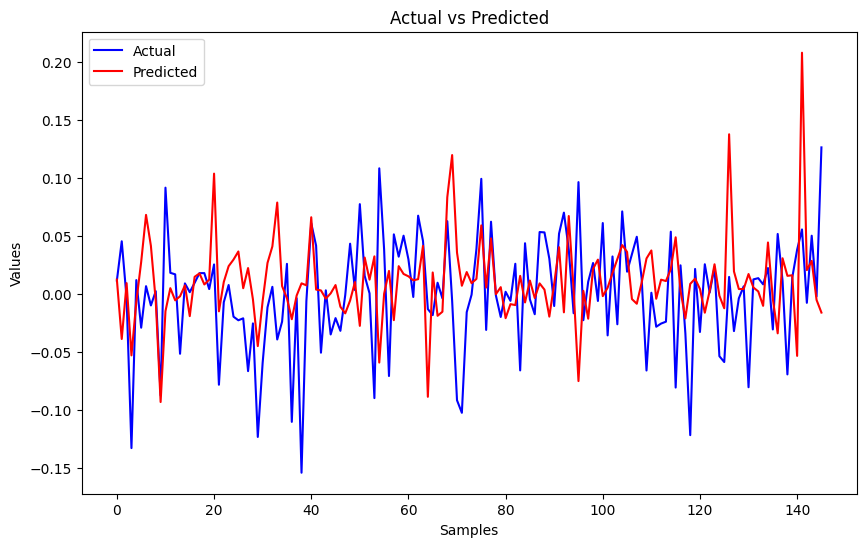

In [160]:
# Calculate MSE
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error on Test Set for Model 1: {mse}')
# Line plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(y_pred_rescaled, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

In [161]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Assuming your dataframe is named df_analysis_2017
# Load your data if it's not already in a DataFrame
# df_analysis_2017 = pd.read_csv('your_data.csv')

# Prepare the dataset
# Exclude the 'Date' column for feature scaling
features = df_analysis_2017_2018.iloc[:, 2:]  # Assuming 'Return' is the second column
target = df_analysis_2017_2018['Return']

# Scale the features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

# Scale the target
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

# Reshape input for CNN [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the CNN model
model_2 = Sequential()
model_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_2.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=1)

# Predict on test data
y_pred = model_2.predict(X_test)

# Invert scaling for predictions and actual values
y_pred_rescaled = scaler_target.inverse_transform(y_pred)
y_test_rescaled = scaler_target.inverse_transform(y_test)

/Users/mehdimouden/Desktop/EPFL/IF/MA3/Fin Machine Learning/BTC NLP/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1639
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0440 
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 
Epoch 10/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 
Epoch 11/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 
Epoch 12/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 
Epoch 13/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 
Epoch 14/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 
Epoch 15/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 

Mean Squared Error on Test Set For Model 2: 0.003791401862419195


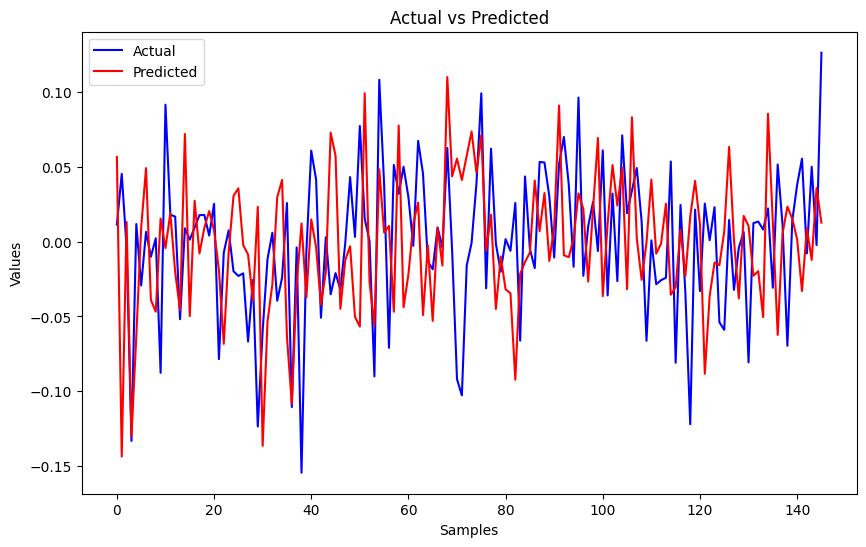

In [162]:
# Calculate MSE in the original scale
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error on Test Set For Model 2: {mse}')

#Line plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(y_pred_rescaled, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

In [163]:
# Assuming df_analysis_2017 is your DataFrame
features = df_analysis_2017_2018.iloc[:, 2:]  # Exclude 'Date' and 'Return'
target = df_analysis_2017_2018['Return']

# Scale the features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

# Scale the target
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model_3 = Sequential()
model_3.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_3.add(LSTM(100))
model_3.add(Dense(1))

# Define Huber loss
huber_loss = Huber(delta=1.0)  # You can adjust the delta value as needed

model_3.compile(optimizer='nadam', loss=huber_loss)

# Train the model
model_3.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=1)

# Predict on test data
y_pred = model_3.predict(X_test)

# Invert scaling for predictions and actual values
y_pred_rescaled = scaler_target.inverse_transform(y_pred)
y_test_rescaled = scaler_target.inverse_transform(y_test)

/Users/mehdimouden/Desktop/EPFL/IF/MA3/Fin Machine Learning/BTC NLP/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1042
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0376 
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 
Epoch 10/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 
Epoch 11/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057  
Epoch 12/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 
Epoch 13/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 
Epoch 14/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 
Epoch 15/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s

Mean Squared Error on Test Set Model 3: 0.004137070545904857


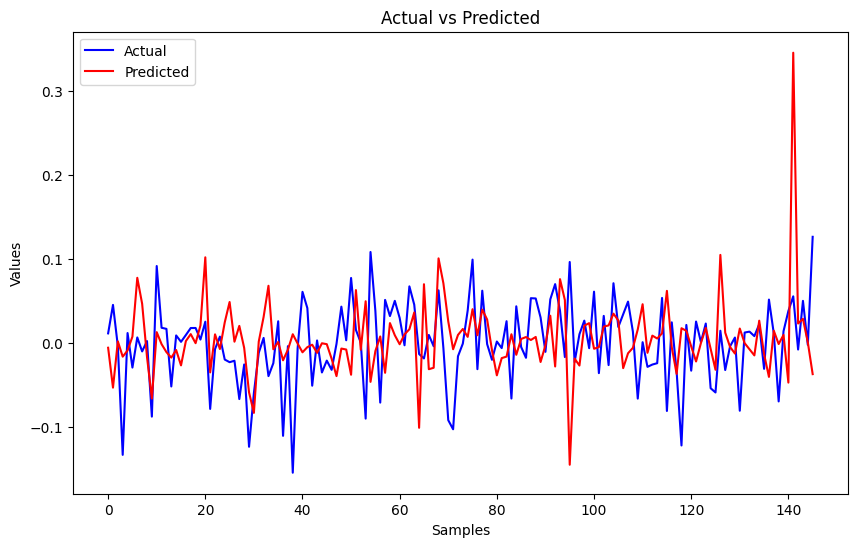

In [164]:
# Calculate MSE in the original scale
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error on Test Set Model 3: {mse}')
# Line plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(y_pred_rescaled, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

In [165]:
# Prepare the dataset
# Exclude the 'Date' column for feature scaling
features = df_analysis_2017_2018.iloc[:, 2:]  # Assuming 'Return' is the second column
target = df_analysis_2017_2018['Return']

# Scale the features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

# Scale the target
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

# Reshape input for CNN [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the CNN model
model_4 = Sequential()
model_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model_4.add(MaxPooling1D(pool_size=2))
model_4.add(Flatten())
model_4.add(Dense(50, activation='relu'))
model_4.add(Dense(1))

# Define Huber loss
huber_loss = Huber(delta=1.0)  # You can adjust the delta value as needed

model_4.compile(optimizer='nadam', loss=huber_loss)

# Train the model
model_4.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=1)

# Predict on test data
y_pred = model_4.predict(X_test)

# Invert scaling for predictions and actual values
y_pred_rescaled = scaler_target.inverse_transform(y_pred)
y_test_rescaled = scaler_target.inverse_transform(y_test)

/Users/mehdimouden/Desktop/EPFL/IF/MA3/Fin Machine Learning/BTC NLP/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0278
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 
Epoch 10/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 
Epoch 11/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 
Epoch 12/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 
Epoch 13/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 
Epoch 14/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 
Epoch 15/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 

Mean Squared Error on Test Set: 0.004971981135684089


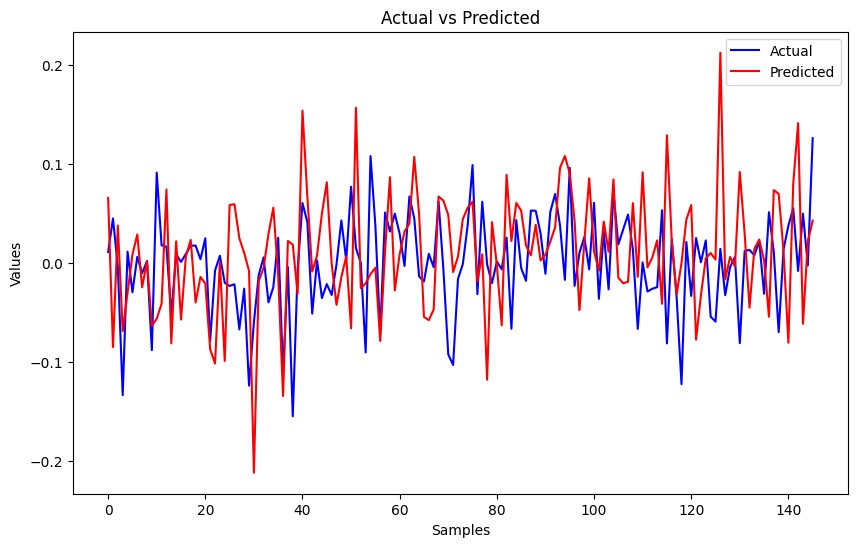

In [166]:
# Calculate MSE in the original scale
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error on Test Set: {mse}')
# Line plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(y_pred_rescaled, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

### II.3 Predicting Returns

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


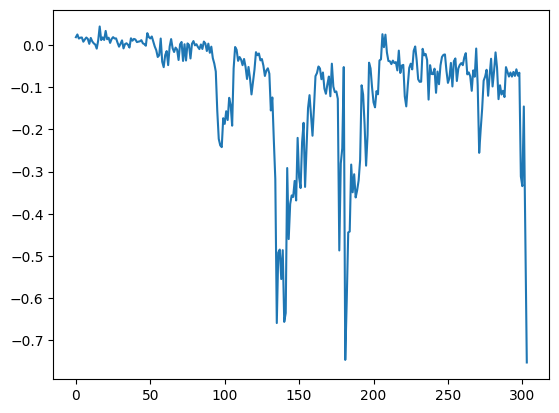

In [176]:
# Exclude the 'Date' column for feature scaling
features_2019 = df_analysis_2019.iloc[:, 2:]  # Assuming 'Return' is the second column
target_2019 = df_analysis_2019['Return']

# Scale the features using the same scaler as before
scaled_features_2019 = scaler_features.transform(features_2019)

# Scale the target using the same scaler as before
scaled_target_2019 = scaler_target.transform(target_2019.values.reshape(-1, 1))

# Reshape input for LSTM [samples, time steps, features]
X_2019 = scaled_features_2019.reshape((scaled_features_2019.shape[0], 1, scaled_features_2019.shape[1]))

# Predict on new data
y_pred_2019 = model_1.predict(X_2019)

# Invert scaling for predictions
y_pred_rescaled_2019 = scaler_target.inverse_transform(y_pred_2019)
plt.plot(y_pred_rescaled_2019)
# Now y_pred_rescaled_2018_2019 contains the predicted returns in their original scale

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


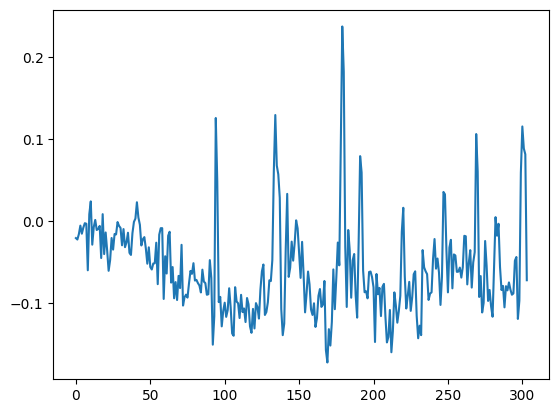

In [171]:
# Assuming df_analysis_2018_2019 is your new DataFrame
# Prepare the dataset
# Exclude the 'Date' column for feature scaling
features_2019 = df_analysis_2019.iloc[:, 2:]  # Assuming 'Return' is the second column
target_2019 = df_analysis_2019['Return']

# Scale the features using the same scaler as before
scaled_features_2019 = scaler_features.transform(features_2019)

# Scale the target using the same scaler as before
scaled_target_2019 = scaler_target.transform(target_2019.values.reshape(-1, 1))

# Reshape input for CNN [samples, features, 1]
X_2019_cnn = scaled_features_2019.reshape((scaled_features_2019.shape[0], scaled_features_2019.shape[1], 1))

# Predict on new data
y_pred_2019_cnn = model_2.predict(X_2019_cnn)  # Replace 'cnn_model' with your CNN model's variable name

# Invert scaling for predictions
y_pred_rescaled_2019_cnn = scaler_target.inverse_transform(y_pred_2019_cnn)
plt.plot(y_pred_rescaled_2019_cnn)
# Now y_pred_rescaled_2018_2019_cnn contains the predicted returns in their original scale


In [173]:
df_trading_strategy_2019 = df_analysis_2019.copy()
df_trading_strategy_2019['Predicted_Return'] = y_pred_rescaled_2019_cnn
Sharpe_Ratio_RM=1
UpBound=1
DownBound=-1
df_trading_strategy_2019['x']=df_trading_strategy_2019['Predicted_Return']/df_trading_strategy_2019['Vol_2W_lag_1']/Sharpe_Ratio_RM

In [172]:
# Merge based on the 'Date' column
df_trading_strategy_2019 = df_trading_strategy_2019.merge(btc[['Date', 'Price']], on='Date', how='left')
df_trading_strategy_2019.head()

,Date,Return,Return_lag_1,Return_lag_2,Return_lag_3,Return_lag_4,Return_lag_5,Price_lag_1,Price_lag_2,Price_lag_3,...,Daily_Volume_Change_lag_5,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Predicted_Return,x,Price_x,Price_y
0,2019-01-01,0.026581,-0.032401,0.011851,-0.026733,0.071040,-0.053916,3742.700439,3865.952637,3820.408691,...,0.055556,4.661841e+09,4.770579e+09,4.991656e+09,5.631554e+09,5.130222e+09,-0.091543,-0.521092,3843.520020,3843.520020
1,2019-01-02,0.025657,0.026581,-0.032401,0.011851,-0.026733,0.071040,3843.520020,3742.700439,3865.952637,...,0.350877,4.324201e+09,4.661841e+09,4.770579e+09,4.991656e+09,5.631554e+09,-0.046461,-0.268930,3943.409424,3943.409424
2,2019-01-03,-0.027422,0.025657,0.026581,-0.032401,0.011851,-0.026733,3943.409424,3843.520020,3742.700439,...,-0.194805,5.244857e+09,4.324201e+09,4.661841e+09,4.770579e+09,4.991656e+09,-0.043018,-0.247024,3836.741211,3836.741211
3,2019-01-04,0.005452,-0.027422,0.025657,0.026581,-0.032401,0.011851,3836.741211,3943.409424,3843.520020,...,0.032258,4.530215e+09,5.244857e+09,4.324201e+09,4.661841e+09,4.770579e+09,-0.067037,-0.458893,3857.717529,3857.717529
4,2019-01-05,-0.003251,0.005452,-0.027422,0.025657,0.026581,-0.032401,3857.717529,3836.741211,3943.409424,...,-0.125000,4.847965e+09,4.530215e+09,5.244857e+09,4.324201e+09,4.661841e+09,-0.051104,-0.382411,3845.194580,3845.194580


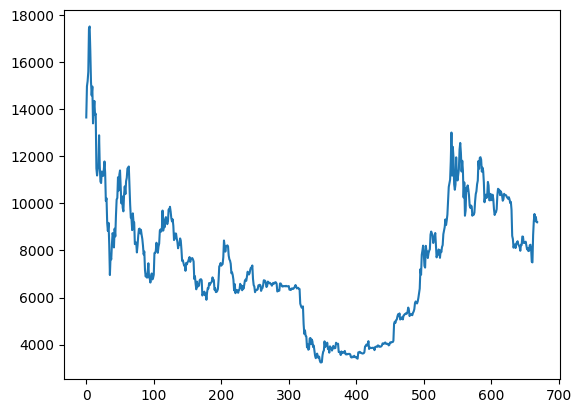

In [149]:
plt.plot(df_trading_strategy_2018_2019['Price'])#/df_trading_strategy_2018_2019['Vol_2W_lag_1'])

In [150]:
print(df_trading_strategy_2018_2019.index)

RangeIndex(start=0, stop=669, step=1)


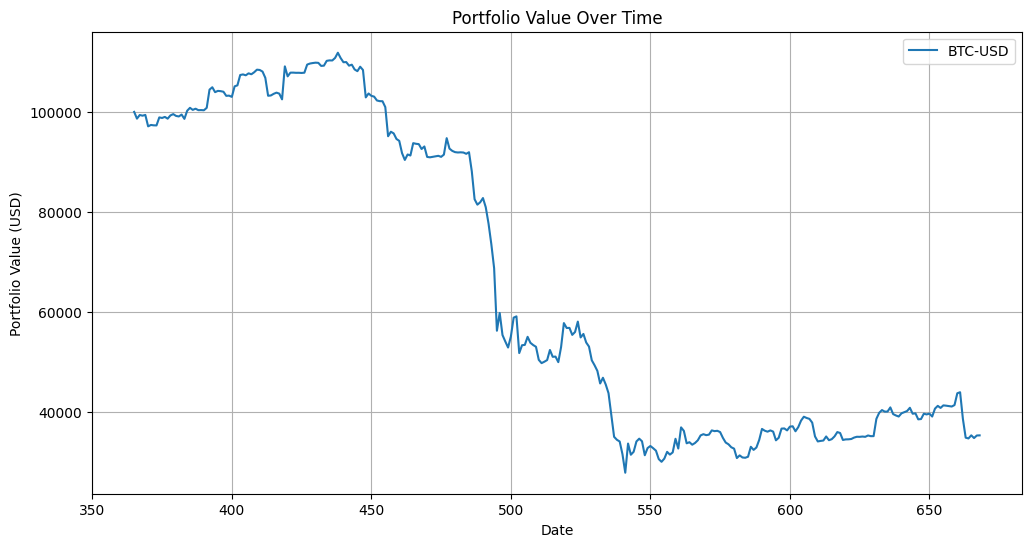

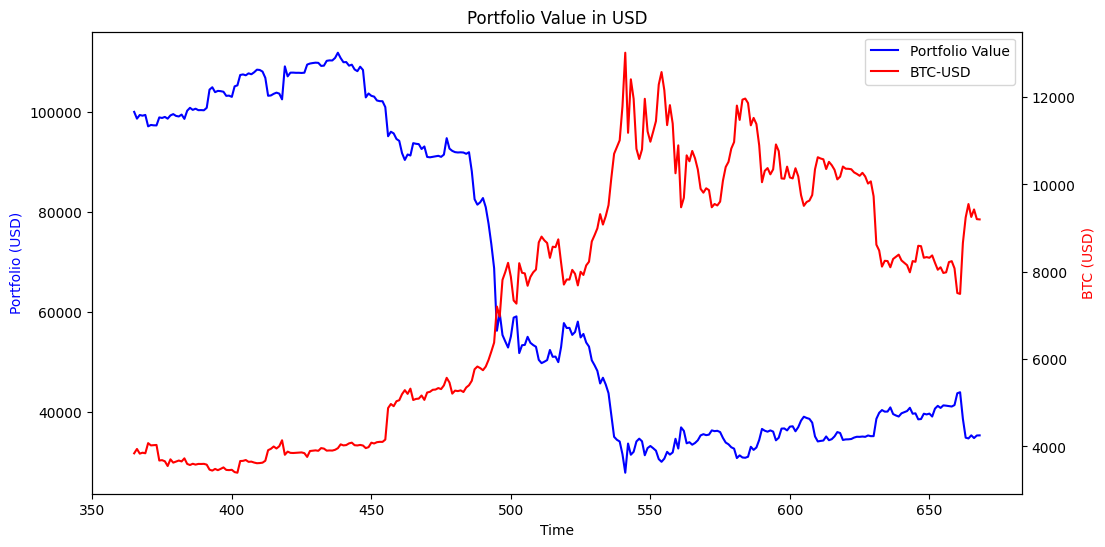

In [175]:
df_trading_strategy_2019 = df_trading_strategy_2018_2019[df_trading_strategy_2018_2019['Date']>=pd.to_datetime('2019-01-01')]

# Define the initial portfolio balance in USD
initial_balance = 100000
total_portfolio_value = 100000

# Initialize portfolio variables
portfolio_balance = initial_balance
btc_holdings = 0

# Create lists to store the portfolio values and BTC holdings over time
portfolio_values_1 = []
btc_holdings_values_1 = []
weights_1 = []

# Iterate through the 'filtered_df_vader' DataFrame
for index, row in df_trading_strategy_2019.iterrows():
    weight = row['x']
    btc_price = row['Price']  # Get the BTC price for the current date

    # Calculate the amount to invest in BTC based on scaled sentiment
    investment_in_btc = weight * total_portfolio_value - btc_holdings * btc_price

    # Update BTC holdings and portfolio balance
    btc_holdings += investment_in_btc / btc_price
    portfolio_balance -= investment_in_btc

    # Calculate the total portfolio value
    total_portfolio_value = portfolio_balance + (btc_holdings * btc_price)

    # Append values to the lists
    portfolio_values_1.append(total_portfolio_value)
    btc_holdings_values_1.append(btc_holdings)
    weights_1.append(weight)
    
import matplotlib.pyplot as plt

# Plot the portfolio value in USD
plt.figure(figsize=(12, 6))

plt.plot(df_trading_strategy_2019.index, portfolio_values_1, label='BTC-USD')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()


# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first curve on the first axis
ax1.plot(df_trading_strategy_2019.index, portfolio_values_1, 'b', label='Portfolio Value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio (USD)', color='b')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second curve on the second axis
ax2.plot(df_trading_strategy_2019.index, df_trading_strategy_2019['Price'], 'r', label='BTC-USD')
ax2.set_ylabel('BTC (USD)', color='r')
# Add labels and title
plt.title('Portfolio Value in USD')

# Add a legend for both curves
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

In [156]:
print(weights_1)

[0.5210924656512588, 0.26892998535587054, 0.24702411318195747, 0.4588927838712792, 0.3824112146895342, 0.22271751278404617, 0.565999734814117, 0.16607797743369168, 0.18659185456846358, 0.4955442348105653, 0.3025524329794323, -0.11964141952778032, -0.1524060341465605, 0.12785430418076782, 0.5355978995848756, 0.17545939009572628, 0.6777503145367034, 0.44818789395883907, 0.4790616229528063, 0.8484383853128807, 0.5132851560844507, 0.4349296604627536, 0.6690336866482242, 0.5384410082207308, 0.48796933742516746, 0.9566110197832811, 1.1437316659830083, 0.7413900194706159, 0.8531342722648418, 0.29751695972746245, 0.06060217463766892, 0.11956423409320162, -0.48572824794144837, 0.2968196079409879, 1.1532770541673014, 1.3424800826130623, 0.4766040080094839, -0.2501914118552065, -0.9183455234397431, 0.31760656379330454, 0.32363725496160795, 1.2257985429108624, 0.6241747929588647, 1.1634406665763026, 0.5367452770935932, 1.1876310869845563, 0.9535053953614602, 0.503959112580634, -0.07017897853525103

### Weekly Returns Approach

In [ ]:
### CHECKPOINT RELOADING ####
tweets_analysis_daily = pd.read_csv('tweets_analysis_daily.csv', sep=';')
tweets_analysis_daily['Date'] = pd.to_datetime(tweets_analysis_daily['Date'])
#tweets_analysis_daily.rename(columns={'Weighted_Average_Sentiment':'WAS', 'Weighted_Average_Sentiment_Change': 'dWAS', 'Daily_Volume' : 'V', 'Daily_Volume_Change' : 'dV'})
tweets_analysis_daily.head()
tweets_analysis_daily_lags = tweets_analysis_daily.copy()
tweets_analysis_daily_lags[f'Daily_Volume_lag_1'] = tweets_analysis_daily_lags['Daily_Volume'].shift(1)
for lag in range(5):
    tweets_analysis_daily_lags[f'Weighted_Average_Sentiment_lag_{lag + 1}'] = tweets_analysis_daily_lags[
        'Weighted_Average_Sentiment'].shift(lag + 1)
    tweets_analysis_daily_lags[f'Daily_Volume_Change_lag_{lag + 1}'] = tweets_analysis_daily_lags[
        'Daily_Volume_Change'].shift(lag + 1)
tweets_analysis_daily_lags.head()

In [177]:
tweets_analysis_daily.head()

,Date,Weighted_Average_Sentiment,Daily_Volume,Weighted_Average_Sentiment_Change,Daily_Volume_Change
0,2016-11-02,-0.179474,7,-0.160952,0.166667
1,2016-11-03,0.391692,3,0.571165,-0.571429
2,2016-11-04,-0.241694,4,-0.633386,0.333333
3,2016-11-05,0.492600,1,0.734294,-0.750000
4,2016-11-06,0.184800,3,-0.307800,2.000000


In [199]:
#tweets_analysis_daily['Timestamp'] = tweets_analysis_daily['Date']
#tweets_analysis_daily.set_index('Date', inplace=True)

# Calculating weekly average sentiment weighted by daily volume
tweets_analysis_daily['Weighted_Sentiment_Volume'] = tweets_analysis_daily['Weighted_Average_Sentiment'] * tweets_analysis_daily['Daily_Volume']
weekly_data = tweets_analysis_daily.resample('W').agg({
    'Weighted_Sentiment_Volume': 'sum',
    'Daily_Volume': 'sum'
})

weekly_data['Weekly_Sentiment'] = weekly_data['Weighted_Sentiment_Volume'] / weekly_data['Daily_Volume']

# Calculating Weekly Sentiment Change, Weekly Volume, and Weekly Volume Change
weekly_data['Weekly_Volume'] = weekly_data['Daily_Volume']
weekly_data['Weekly_Sentiment_Change'] = weekly_data['Weekly_Sentiment'].diff()
weekly_data['Weekly_Volume_Change'] = weekly_data['Weekly_Volume'].pct_change()

# Selecting the final columns
tweets_analysis_weekly = weekly_data[['Weekly_Sentiment', 'Weekly_Sentiment_Change', 'Weekly_Volume', 'Weekly_Volume_Change']]

# Resetting index to have 'Date' as a column
tweets_analysis_weekly.reset_index(inplace=True)
tweets_analysis_weekly.dropna(subset=['Weekly_Volume_Change'])
# Displaying the first few rows of the final weekly data
tweets_analysis_weekly.head()

,Date,Weekly_Sentiment,Weekly_Sentiment_Change,Weekly_Volume,Weekly_Volume_Change
0,2016-11-06,-0.000057,NaN,18,NaN
1,2016-11-13,0.268778,0.268835,25,0.388889
2,2016-11-20,0.218767,-0.050012,31,0.240000
3,2016-11-27,0.246155,0.027388,28,-0.096774
4,2016-12-04,-0.105114,-0.351269,37,0.321429


In [251]:
############################# Extracting Data from Bitcoin #########################################
# Define the date range for which you want to fetch historical data
start_date_2 = "2016-06-01"
end_date = "2019-12-01"

btcusd_2 = yf.Ticker("BTC-USD").history(start=start_date_2, end=end_date)

btc_2 = btcusd_2[['Close', 'Volume']]
btc_2.reset_index(inplace=True)
btc_2['Date'] = pd.to_datetime(btc_2['Date'])
btc_2['Date'] = btc_2['Date'].dt.tz_convert(None)
btc_2['Log'] = np.log(btc_2['Close'])
btc_2['Return']=btc_2['Log'].diff()
btc_2['Weekly_Return']=btc_2['Log'].diff(periods=7)
# Rename the columns
btc_2 = btc_2.rename(columns={'Close': 'Price'})
# Set 'Date' as the index
btc_2['Timestamp']=btc_2['Date']
btc_2.set_index('Timestamp',inplace=True)
# Calculate the squared returns
btc_2['Return_squared'] = btc_2['Return'] ** 2
# Compute the rolling 14 days volatility
btc_2['Vol_2W'] = np.sqrt(btc_2['Return_squared'].rolling(window=14, min_periods=14).sum())

#Computing lags for Price, Return and Volatility
for lag in range(5):
    btc_2[f'Vol_2W_lag_{7+(lag)*14}'] = btc_2['Vol_2W'].shift(7+(lag)*14)
for lag in range(5):
    btc_2[f'Weekly_Return_lag_{(lag+1)*7}'] = btc_2['Weekly_Return'].shift((lag+1)*7)
    btc_2[f'Volume_lag_{(lag+7)}'] = btc_2['Volume'].shift((lag+7))
    btc_2[f'Price_lag_{lag+7}'] = btc_2['Price'].shift((lag+7))
btc_2['Price_lag_14'] = btc_2['Price'].shift(14)
btc_2['Price_lag_21'] = btc_2['Price'].shift(21)
btc_2['Price_lag_28'] = btc_2['Price'].shift(28)
btc_2 = btc_2[btc_2['Date']>= pd.to_datetime('2016-11-01')]
btc_2.head(30)

/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_90984/4145619618.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_2['Date'] = pd.to_datetime(btc_2['Date'])
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_90984/4145619618.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_2['Date'] = btc_2['Date'].dt.tz_convert(None)
/var/folders/rh/41k8kg5x2js8n7lgg1fb7bj40000gn/T/ipykernel_90984/4145619618.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Date,Price,Volume,Log,Return,Weekly_Return,Return_squared,Vol_2W,Vol_2W_lag_7,Vol_2W_lag_21,...,Price_lag_9,Weekly_Return_lag_28,Volume_lag_10,Price_lag_10,Weekly_Return_lag_35,Volume_lag_11,Price_lag_11,Price_lag_14,Price_lag_21,Price_lag_28
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-01,2016-11-01,729.793030,130527000,6.592761,0.040293,0.104182,1.623530e-03,0.077588,0.042242,0.038286,...,657.070984,0.006639,78556496.0,657.294006,-0.003534,55951000.0,632.828003,637.960022,641.072021,610.203979
2016-11-02,2016-11-02,740.828979,84865200,6.607770,0.015009,0.088174,2.252649e-04,0.078151,0.051847,0.038969,...,653.760986,0.012788,54474600.0,657.070984,0.012612,78556496.0,657.294006,630.520020,636.192017,612.510986
2016-11-03,2016-11-03,688.700012,172808000,6.534806,-0.072964,0.000562,5.323748e-03,0.106916,0.053868,0.038947,...,657.588013,0.012026,62218200.0,653.760986,0.015633,54474600.0,657.070984,630.856995,636.786011,613.020996
2016-11-04,2016-11-04,703.234985,99907696,6.555691,0.020885,0.019505,4.361964e-04,0.108892,0.053609,0.038785,...,678.304016,0.012041,90378800.0,657.588013,0.011369,62218200.0,653.760986,632.828003,640.377991,617.120972
2016-11-05,2016-11-05,703.418030,53752300,6.555951,0.000260,-0.015602,6.773281e-08,0.102072,0.064167,0.038255,...,688.312988,0.008312,88877104.0,678.304016,0.018672,90378800.0,657.588013,657.294006,638.645996,619.107971
2016-11-06,2016-11-06,711.521973,59902200,6.567406,0.011455,0.013667,1.312158e-04,0.102712,0.066431,0.038206,...,689.651001,0.009547,96105296.0,688.312988,0.016615,88877104.0,678.304016,657.070984,641.630981,616.752014
2016-11-07,2016-11-07,703.130981,65047100,6.555543,-0.011863,0.003075,1.407333e-04,0.103272,0.066334,0.038342,...,714.479004,0.011146,81145504.0,689.651001,0.006704,96105296.0,688.312988,653.760986,639.192993,618.994019
2016-11-08,2016-11-08,709.848022,79660800,6.565051,0.009508,-0.027710,9.039640e-05,0.103544,0.077588,0.038260,...,701.864014,0.049349,134760992.0,714.479004,0.006639,81145504.0,689.651001,657.588013,637.960022,641.072021
2016-11-09,2016-11-09,723.273010,132429000,6.583787,0.018736,-0.023983,3.510326e-04,0.100550,0.078151,0.039840,...,700.971985,0.037934,100665000.0,701.864014,0.012788,134760992.0,714.479004,678.304016,630.520020,636.192017


In [252]:
tweets_analysis_weekly_lags = tweets_analysis_weekly.copy()
tweets_analysis_weekly_lags[f'Weekly_Volume_lag_1'] = tweets_analysis_weekly_lags['Weekly_Volume'].shift(1)
for lag in range(4):
    tweets_analysis_weekly_lags[f'Weekly_Sentiment_lag_{lag + 1}'] = tweets_analysis_weekly_lags[
        'Weekly_Sentiment'].shift(lag + 1)
    tweets_analysis_weekly_lags[f'Weekly_Volume_Change_lag_{lag + 1}'] = tweets_analysis_weekly_lags[
        'Weekly_Volume_Change'].shift(lag + 1)
tweets_analysis_weekly_lags.head()
df_merge_weekly = tweets_analysis_weekly_lags.merge(btc_2, left_on='Date', right_on='Date', how='left')
df_merge_weekly.head(1000)

,Date,Weekly_Sentiment,Weekly_Sentiment_Change,Weekly_Volume,Weekly_Volume_Change,Weekly_Volume_lag_1,Weekly_Sentiment_lag_1,Weekly_Volume_Change_lag_1,Weekly_Sentiment_lag_2,Weekly_Volume_Change_lag_2,...,Price_lag_9,Weekly_Return_lag_28,Volume_lag_10,Price_lag_10,Weekly_Return_lag_35,Volume_lag_11,Price_lag_11,Price_lag_14,Price_lag_21,Price_lag_28
0,2016-11-06,-0.000057,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,...,689.651001,0.009547,9.610530e+07,688.312988,0.016615,8.887710e+07,678.304016,657.070984,641.630981,616.752014
1,2016-11-13,0.268778,0.268835,25,0.388889,18.0,-0.000057,NaN,NaN,NaN,...,703.234985,0.039546,1.728080e+08,688.700012,0.009547,8.486520e+07,740.828979,701.864014,657.070984,641.630981
2,2016-11-20,0.218767,-0.050012,31,0.240000,25.0,0.268778,0.388889,-0.000057,NaN,...,716.411011,0.023779,6.880780e+07,715.533997,0.039546,1.324290e+08,723.273010,711.521973,701.864014,657.070984
3,2016-11-27,0.246155,0.027388,28,-0.096774,31.0,0.218767,0.240000,0.268778,0.388889,...,751.585022,0.065948,1.085790e+08,740.976990,0.023779,1.412940e+08,744.197998,702.031006,711.521973,701.864014
4,2016-12-04,-0.105114,-0.351269,37,0.321429,28.0,0.246155,-0.096774,0.218767,0.240000,...,741.648987,0.013667,8.591930e+07,740.289001,0.065948,7.654380e+07,744.593994,731.026001,702.031006,711.521973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2019-10-27,0.216436,-0.010550,32900,0.174832,28004.0,0.226986,0.043213,0.262001,0.014781,...,7973.207520,-0.217219,1.431305e+10,8103.911133,-0.027166,1.607165e+10,8047.526855,8321.005859,7988.155762,8104.185547
156,2019-11-03,0.245440,0.029004,29615,-0.099848,32900.0,0.216436,0.174832,0.226986,0.043213,...,8660.700195,-0.014421,1.626871e+10,7493.488770,-0.217219,2.194288e+10,7514.671875,8222.078125,8321.005859,7988.155762
157,2019-11-10,0.243391,-0.002049,28575,-0.035117,29615.0,0.245440,-0.099848,0.216436,0.174832,...,9261.104492,0.040823,2.658365e+10,9199.584961,-0.014421,2.770653e+10,9205.726562,9551.714844,8222.078125,8321.005859
158,2019-11-17,0.303052,0.059661,28190,-0.013473,28575.0,0.243391,-0.035117,0.245440,-0.099848,...,8804.880859,-0.011960,2.270038e+10,9267.561523,0.040823,2.313390e+10,9360.879883,9235.354492,9551.714844,8222.078125


In [243]:
df_merge_weekly.dropna(subset=['Weekly_Volume_Change_lag_4'])

,Date,Weekly_Sentiment,Weekly_Sentiment_Change,Weekly_Volume,Weekly_Volume_Change,Weekly_Volume_lag_1,Weekly_Sentiment_lag_1,Weekly_Volume_Change_lag_1,Weekly_Sentiment_lag_2,Weekly_Volume_Change_lag_2,...,Price_lag_9,Weekly_Return_lag_28,Volume_lag_10,Price_lag_10,Weekly_Return_lag_35,Volume_lag_11,Price_lag_11,Price_lag_14,Price_lag_21,Price_lag_28
5,2016-12-11,0.176330,0.281443,36,-0.027027,37.0,-0.105114,0.321429,0.246155,-0.096774,...,777.943970,-0.013429,8.046190e+07,756.773987,0.013667,8.407080e+07,745.690979,732.034973,731.026001,702.031006
6,2016-12-18,0.116043,-0.060287,3771,103.750000,36.0,0.176330,-0.027027,-0.105114,0.321429,...,772.794006,0.040471,8.011190e+07,770.809998,-0.013429,9.642610e+07,768.132019,773.872009,732.034973,731.026001
7,2016-12-25,0.115210,-0.000833,2921,-0.225404,3771.0,0.116043,103.750000,0.176330,-0.027027,...,784.906982,0.001379,8.158010e+07,778.088013,0.040471,7.597900e+07,781.481018,769.731018,773.872009,732.034973
8,2017-01-01,0.159724,0.044514,72,-0.975351,2921.0,0.115210,-0.225404,0.116043,103.750000,...,921.984009,0.055578,2.000270e+08,864.539978,0.001379,1.555760e+08,834.281006,790.530029,769.731018,773.872009
9,2017-01-08,0.124957,-0.034767,95,0.319444,72.0,0.159724,-0.975351,0.115210,-0.225404,...,961.237976,-0.005365,1.993200e+08,973.497009,0.055578,2.366300e+08,975.921021,896.182983,790.530029,769.731018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2019-10-27,0.216436,-0.010550,32900,0.174832,28004.0,0.226986,0.043213,0.262001,0.014781,...,7973.207520,-0.217219,1.431305e+10,8103.911133,-0.027166,1.607165e+10,8047.526855,8321.005859,7988.155762,8104.185547
156,2019-11-03,0.245440,0.029004,29615,-0.099848,32900.0,0.216436,0.174832,0.226986,0.043213,...,8660.700195,-0.014421,1.626871e+10,7493.488770,-0.217219,2.194288e+10,7514.671875,8222.078125,8321.005859,7988.155762
157,2019-11-10,0.243391,-0.002049,28575,-0.035117,29615.0,0.245440,-0.099848,0.216436,0.174832,...,9261.104492,0.040823,2.658365e+10,9199.584961,-0.014421,2.770653e+10,9205.726562,9551.714844,8222.078125,8321.005859
158,2019-11-17,0.303052,0.059661,28190,-0.013473,28575.0,0.243391,-0.035117,0.245440,-0.099848,...,8804.880859,-0.011960,2.270038e+10,9267.561523,0.040823,2.313390e+10,9360.879883,9235.354492,9551.714844,8222.078125


In [253]:
df_analysis_weekly = df_merge_weekly[['Date', 'Weekly_Return', 'Weekly_Return_lag_7', 'Weekly_Return_lag_14', 'Weekly_Return_lag_21', 'Weekly_Return_lag_28', 'Weekly_Return_lag_35', 'Price_lag_7', 'Price_lag_8', 'Price_lag_9', 'Price_lag_10', 'Price_lag_11', 'Price_lag_14', 'Price_lag_21', 'Price_lag_28', 'Vol_2W_lag_7', 'Vol_2W_lag_21', 'Vol_2W_lag_35', 'Vol_2W_lag_49', 'Vol_2W_lag_63', 'Weekly_Sentiment_lag_1', 'Weekly_Sentiment_lag_2', 'Weekly_Sentiment_lag_3', 'Weekly_Sentiment_lag_4', 'Weekly_Volume_lag_1', 'Weekly_Volume_Change_lag_1', 'Weekly_Volume_Change_lag_2', 'Weekly_Volume_Change_lag_3', 'Weekly_Volume_Change_lag_4', 'Volume_lag_7', 'Volume_lag_8', 'Volume_lag_9', 'Volume_lag_10', 'Volume_lag_11']]
df_analysis_weekly = df_analysis_weekly.dropna(subset=['Weekly_Volume_Change_lag_4'])
df_analysis_weekly.head(10)

,Date,Weekly_Return,Weekly_Return_lag_7,Weekly_Return_lag_14,Weekly_Return_lag_21,Weekly_Return_lag_28,Weekly_Return_lag_35,Price_lag_7,Price_lag_8,Price_lag_9,...,Weekly_Volume_lag_1,Weekly_Volume_Change_lag_1,Weekly_Volume_Change_lag_2,Weekly_Volume_Change_lag_3,Weekly_Volume_Change_lag_4,Volume_lag_7,Volume_lag_8,Volume_lag_9,Volume_lag_10,Volume_lag_11
5,2016-12-11,-0.005365,0.055578,0.001379,0.040471,-0.013429,0.013667,773.872009,771.155029,777.943970,...,37.0,0.321429,-0.096774,0.240000,0.388889,60557900.0,69547296.0,127605000.0,80461904.0,84070800.0
6,2016-12-18,0.026663,-0.005365,0.055578,0.001379,0.040471,-0.013429,769.731018,774.650024,772.794006,...,36.0,-0.027027,0.321429,-0.096774,0.240000,57313400.0,53843100.0,68705296.0,80111904.0,96426096.0
7,2016-12-25,0.125441,0.026663,-0.005365,0.055578,0.001379,0.040471,790.530029,790.828979,784.906982,...,3771.0,103.750000,-0.027027,0.321429,-0.096774,60524400.0,78989800.0,83608200.0,81580096.0,75979000.0
8,2017-01-01,0.107934,0.125441,0.026663,-0.005365,0.055578,0.001379,896.182983,898.822021,921.984009,...,2921.0,-0.225404,103.750000,-0.027027,0.321429,143664992.0,137727008.0,275564000.0,200027008.0,155576000.0
9,2017-01-08,-0.091318,0.107934,0.125441,0.026663,-0.005365,0.055578,998.325012,963.742981,961.237976,...,72.0,-0.975351,-0.225404,103.750000,-0.027027,147775008.0,99135104.0,187474000.0,199320000.0,236630000.0
10,2017-01-15,-0.103267,-0.091318,0.107934,0.125441,0.026663,-0.005365,911.198975,908.585022,902.200989,...,95.0,0.319444,-0.975351,-0.225404,103.750000,158715008.0,279550016.0,351876000.0,510199008.0,344945984.0
11,2017-01-22,0.117946,-0.103267,-0.091318,0.107934,0.125441,0.026663,821.797974,818.411987,823.984009,...,75.0,-0.210526,0.319444,-0.975351,-0.225404,71013600.0,93063296.0,168968000.0,222326000.0,310928992.0
12,2017-01-29,-0.005614,0.117946,-0.103267,-0.091318,0.107934,0.125441,924.672974,921.789001,895.026001,...,69.0,-0.080000,-0.210526,0.319444,-0.975351,116573000.0,111158000.0,86728400.0,105625000.0,225676992.0
13,2017-02-05,0.110903,-0.005614,0.117946,-0.103267,-0.091318,0.107934,919.495972,921.590027,919.750000,...,45.0,-0.347826,-0.080000,-0.210526,0.319444,60851700.0,68979600.0,125594000.0,131958000.0,120831000.0
14,2017-02-12,-0.027792,0.110903,-0.005614,0.117946,-0.103267,-0.091318,1027.339966,1042.900024,1029.910034,...,39.0,-0.133333,-0.347826,-0.080000,-0.210526,114208000.0,155064000.0,201278000.0,145820992.0,150110000.0


In [219]:
df_analysis_weekly_light = df_merge_weekly[['Date', 'Weekly_Return', 'Return_lag_1', 'Return_lag_2', 'Price_lag_1', 'Price_lag_7', 'Price_lag_14', 'Price_lag_21', 'Price_lag_28', 'Vol_2W_lag_1', 'Vol_2W_lag_15', 'Vol_2W_lag_29', 'Weekly_Sentiment_lag_1', 'Weekly_Sentiment_lag_2', 'Weekly_Volume_lag_1', 'Weekly_Volume_Change_lag_1', 'Weekly_Volume_Change_lag_2']]
df_analysis_weekly_light = df_analysis_weekly_light.dropna(subset=['Vol_2W_lag_29'])
df_analysis_weekly_light.head(10)

,Date,Weekly_Return,Return_lag_1,Return_lag_2,Price_lag_1,Price_lag_7,Price_lag_14,Price_lag_21,Price_lag_28,Vol_2W_lag_1,Vol_2W_lag_15,Vol_2W_lag_29,Weekly_Sentiment_lag_1,Weekly_Sentiment_lag_2,Weekly_Volume_lag_1,Weekly_Volume_Change_lag_1,Weekly_Volume_Change_lag_2
6,2016-12-18,0.026663,0.007517,0.008726,790.828979,769.731018,773.872009,732.034973,731.026001,0.029666,0.051374,0.058600,0.176330,-0.105114,36.0,-0.027027,0.321429
7,2016-12-25,0.125441,-0.025443,0.064330,898.822021,790.530029,769.731018,773.872009,732.034973,0.090610,0.042380,0.060817,0.116043,0.176330,3771.0,103.750000,-0.027027
8,2017-01-01,0.107934,0.002603,-0.012673,963.742981,896.182983,790.530029,769.731018,773.872009,0.104676,0.029666,0.051374,0.115210,0.116043,2921.0,-0.225404,103.750000
9,2017-01-08,-0.091318,0.007051,-0.116209,908.585022,998.325012,896.182983,790.530029,769.731018,0.214837,0.090610,0.042380,0.159724,0.115210,72.0,-0.975351,-0.225404
10,2017-01-15,-0.103267,-0.006785,0.023515,818.411987,911.198975,998.325012,896.182983,790.530029,0.262280,0.104676,0.029666,0.124957,0.159724,95.0,0.319444,-0.975351
11,2017-01-22,0.117946,0.029464,-0.004511,921.789001,821.797974,911.198975,998.325012,896.182983,0.187845,0.214837,0.090610,0.032362,0.124957,75.0,-0.210526,0.319444
12,2017-01-29,-0.005614,0.001999,0.002356,921.590027,924.672974,821.797974,911.198975,998.325012,0.104642,0.262280,0.104676,0.108991,0.032362,69.0,-0.080000,-0.210526
13,2017-02-05,0.110903,0.012534,0.017741,1042.900024,919.495972,924.672974,821.797974,911.198975,0.074684,0.187845,0.214837,0.137781,0.108991,45.0,-0.347826,-0.080000
14,2017-02-12,-0.027792,0.015831,-0.005758,1004.450012,1027.339966,919.495972,924.672974,821.797974,0.098642,0.104642,0.262280,0.119950,0.137781,39.0,-0.133333,-0.347826
15,2017-02-19,0.047579,0.007817,0.018104,1054.420044,999.181030,1027.339966,919.495972,924.672974,0.081546,0.074684,0.187845,0.187436,0.119950,47.0,0.205128,-0.133333


In [254]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import Huber
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [255]:
#We isolate datasets to build the model (2017) and then to trade (2018-19)
df_analysis_2017_2018_weekly = df_analysis_weekly[
    (df_analysis_weekly['Date'] < pd.to_datetime('2019-01-01')) & (df_analysis_weekly['Date'] >= pd.to_datetime('2017-01-01'))]
df_analysis_2019_weekly = df_analysis_weekly[
    (df_analysis_weekly['Date'] < pd.to_datetime('2019-11-02')) & (df_analysis_weekly['Date'] >= pd.to_datetime('2019-01-01'))]

In [256]:
# Normalize the features (excluding the 'Date' column)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_analysis_2017_2018_weekly.iloc[:, 1:])  # Exclude 'Date'

# Split into features and target
X = scaled_data[:, 1:]  # All features except 'Return'
y = scaled_data[:, 0]  # 'Return' is the target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model_1 = Sequential()
model_1.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1.add(LSTM(100, return_sequences=False))
model_1.add(Dense(1))

model_1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_1.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=1)

# Predict on test data
y_pred = model_1.predict(X_test)

# Inverting the scaling for target feature
y_test_rescaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), X.shape[1]))), axis=1))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), X.shape[1]))), axis=1))[:, 0]

/Users/mehdimouden/Desktop/EPFL/IF/MA3/Fin Machine Learning/BTC NLP/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.3240
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2899 
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2499 
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2149 
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1752 
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1479
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1149 
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0848 
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0679 
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0720 
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0749 
Epoch 12/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0795 
Epoch 13/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0767 
Epoch 14/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0637 
Epoch 15/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0570 
Epoch

Mean Squared Error on Test Set for Model 1: 0.021196405680573672


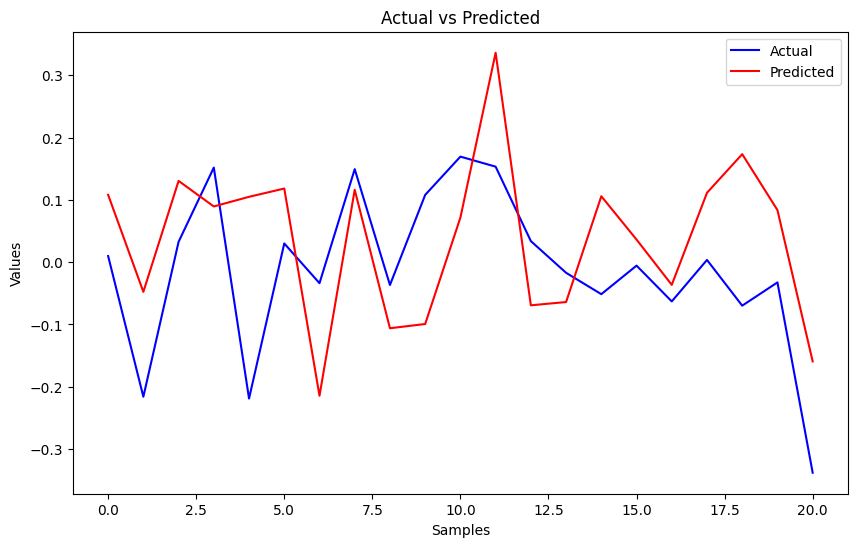

In [257]:
# Calculate MSE
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error on Test Set for Model 1: {mse}')
# Line plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(y_pred_rescaled, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

In [258]:
# Prepare the dataset
# Exclude the 'Date' column for feature scaling
features = df_analysis_2017_2018_weekly.iloc[:, 2:]  # Assuming 'Return' is the second column
target = df_analysis_2017_2018_weekly['Weekly_Return']

# Scale the features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

# Scale the target
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

# Reshape input for CNN [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the CNN model
model_4 = Sequential()
model_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model_4.add(MaxPooling1D(pool_size=2))
model_4.add(Flatten())
model_4.add(Dense(50, activation='relu'))
model_4.add(Dense(1))

# Define Huber loss
huber_loss = Huber(delta=1.0)  # You can adjust the delta value as needed

model_4.compile(optimizer='nadam', loss=huber_loss)

# Train the model
model_4.fit(X_train, y_train, epochs=1000, batch_size=64, verbose=1)

# Predict on test data
y_pred = model_4.predict(X_test)

# Invert scaling for predictions and actual values
y_pred_rescaled = scaler_target.inverse_transform(y_pred)
y_test_rescaled = scaler_target.inverse_transform(y_test)


/Users/mehdimouden/Desktop/EPFL/IF/MA3/Fin Machine Learning/BTC NLP/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1272
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0515 
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0320 
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0314 
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0297 
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304 
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0212 
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0190 
Epoch 12/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 
Epoch 13/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 
Epoch 14/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 
Epoch 15/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0175 
Epoc

Mean Squared Error on Test Set: 0.03234195638988674


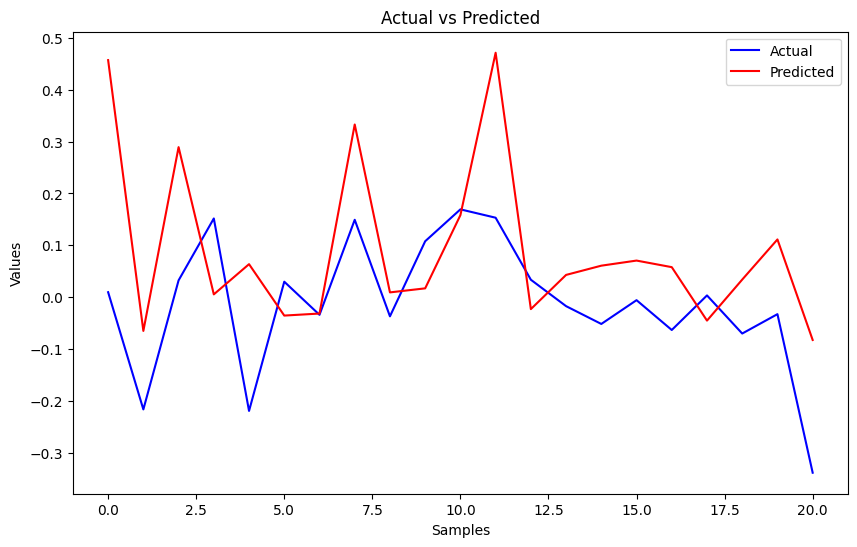

In [259]:
# Calculate MSE in the original scale
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error on Test Set: {mse}')
# Line plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(y_pred_rescaled, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

### Weekly Trading Strategies

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


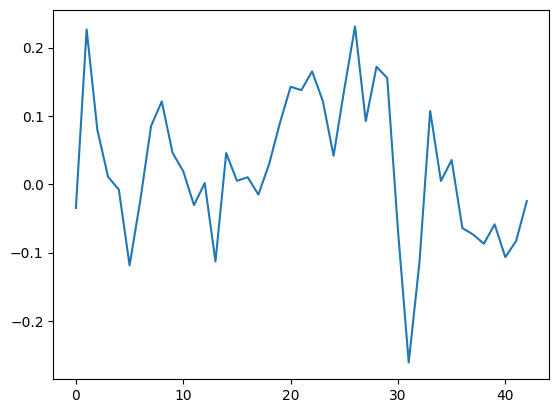

In [260]:
# Assuming df_analysis_2018_2019 is your new DataFrame
# Prepare the dataset
# Exclude the 'Date' column for feature scaling
features_2019 = df_analysis_2019_weekly.iloc[:, 2:]  # Assuming 'Return' is the second column
target_2019 = df_analysis_2019_weekly['Weekly_Return']

# Scale the features using the same scaler as before
scaled_features_2019 = scaler_features.transform(features_2019)

# Scale the target using the same scaler as before
scaled_target_2019 = scaler_target.transform(target_2019.values.reshape(-1, 1))

# Reshape input for CNN [samples, features, 1]
X_2019_cnn = scaled_features_2019.reshape((scaled_features_2019.shape[0], scaled_features_2019.shape[1], 1))

# Predict on new data
y_pred_2019_cnn = model_4.predict(X_2019_cnn)  # Replace 'cnn_model' with your CNN model's variable name

# Invert scaling for predictions
y_pred_rescaled_2019_cnn = scaler_target.inverse_transform(y_pred_2019_cnn)
plt.plot(y_pred_rescaled_2019_cnn)
# Now y_pred_rescaled_2018_2019_cnn contains the predicted returns in their original scale

In [282]:
df_analysis_weekly

,Date,Weekly_Return,Weekly_Return_lag_7,Weekly_Return_lag_14,Weekly_Return_lag_21,Weekly_Return_lag_28,Weekly_Return_lag_35,Price_lag_7,Price_lag_8,Price_lag_9,...,Weekly_Volume_lag_1,Weekly_Volume_Change_lag_1,Weekly_Volume_Change_lag_2,Weekly_Volume_Change_lag_3,Weekly_Volume_Change_lag_4,Volume_lag_7,Volume_lag_8,Volume_lag_9,Volume_lag_10,Volume_lag_11
5,2016-12-11,-0.005365,0.055578,0.001379,0.040471,-0.013429,0.013667,773.872009,771.155029,777.943970,...,37.0,0.321429,-0.096774,0.240000,0.388889,6.055790e+07,6.954730e+07,1.276050e+08,8.046190e+07,8.407080e+07
6,2016-12-18,0.026663,-0.005365,0.055578,0.001379,0.040471,-0.013429,769.731018,774.650024,772.794006,...,36.0,-0.027027,0.321429,-0.096774,0.240000,5.731340e+07,5.384310e+07,6.870530e+07,8.011190e+07,9.642610e+07
7,2016-12-25,0.125441,0.026663,-0.005365,0.055578,0.001379,0.040471,790.530029,790.828979,784.906982,...,3771.0,103.750000,-0.027027,0.321429,-0.096774,6.052440e+07,7.898980e+07,8.360820e+07,8.158010e+07,7.597900e+07
8,2017-01-01,0.107934,0.125441,0.026663,-0.005365,0.055578,0.001379,896.182983,898.822021,921.984009,...,2921.0,-0.225404,103.750000,-0.027027,0.321429,1.436650e+08,1.377270e+08,2.755640e+08,2.000270e+08,1.555760e+08
9,2017-01-08,-0.091318,0.107934,0.125441,0.026663,-0.005365,0.055578,998.325012,963.742981,961.237976,...,72.0,-0.975351,-0.225404,103.750000,-0.027027,1.477750e+08,9.913510e+07,1.874740e+08,1.993200e+08,2.366300e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2019-10-27,0.149898,-0.011960,0.040823,-0.014421,-0.217219,-0.027166,8222.078125,7988.560547,7973.207520,...,28004.0,0.043213,0.014781,-0.162641,0.062883,1.550425e+10,1.379783e+10,1.565159e+10,1.431305e+10,1.607165e+10
156,2019-11-03,-0.033682,0.149898,-0.011960,0.040823,-0.014421,-0.217219,9551.714844,9244.972656,8660.700195,...,32900.0,0.174832,0.043213,0.014781,-0.162641,3.259313e+10,4.449626e+10,2.870507e+10,1.626871e+10,2.194288e+10
157,2019-11-10,-0.019664,-0.033682,0.149898,-0.011960,0.040823,-0.014421,9235.354492,9324.717773,9261.104492,...,29615.0,-0.099848,0.174832,0.043213,0.014781,2.113222e+10,2.124268e+10,2.432469e+10,2.658365e+10,2.770653e+10
158,2019-11-17,-0.054177,-0.019664,-0.033682,0.149898,-0.011960,0.040823,9055.526367,8813.582031,8804.880859,...,28575.0,-0.035117,-0.099848,0.174832,0.043213,2.058792e+10,1.757863e+10,2.433304e+10,2.270038e+10,2.313390e+10


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step 


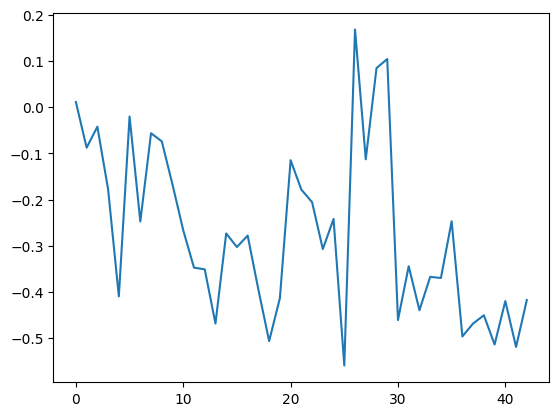

In [261]:
# Exclude the 'Date' column for feature scaling
features_2019 = df_analysis_2019_weekly.iloc[:, 2:]  # Assuming 'Return' is the second column
target_2019 = df_analysis_2019_weekly['Weekly_Return']

# Scale the features using the same scaler as before
scaled_features_2019 = scaler_features.transform(features_2019)

# Scale the target using the same scaler as before
scaled_target_2019 = scaler_target.transform(target_2019.values.reshape(-1, 1))

# Reshape input for LSTM [samples, time steps, features]
X_2019 = scaled_features_2019.reshape((scaled_features_2019.shape[0], 1, scaled_features_2019.shape[1]))

# Predict on new data
y_pred_2019 = model_1.predict(X_2019)

# Invert scaling for predictions
y_pred_rescaled_2019 = scaler_target.inverse_transform(y_pred_2019)
plt.plot(y_pred_rescaled_2019)

In [277]:
df_trading_strategy_2019_weekly = df_analysis_2019_weekly.copy()
df_trading_strategy_2019_weekly['Predicted_Return'] = y_pred_rescaled_2019
Sharpe_Ratio_RM=1
UpBound=1
DownBound=-1
df_trading_strategy_2019_weekly['x']=df_trading_strategy_2019_weekly['Predicted_Return']/df_trading_strategy_2019_weekly['Vol_2W_lag_7']/Sharpe_Ratio_RM

In [280]:
# Merge based on the 'Date' column
df_trading_strategy_2019_weekly = df_trading_strategy_2019_weekly.merge(btc_2[['Date', 'Price']], on='Date', how='left')
df_trading_strategy_2019_weekly.head()

,Date,Weekly_Return,Weekly_Return_lag_7,Weekly_Return_lag_14,Weekly_Return_lag_21,Weekly_Return_lag_28,Weekly_Return_lag_35,Price_lag_7,Price_lag_8,Price_lag_9,...,Weekly_Volume_Change_lag_3,Weekly_Volume_Change_lag_4,Volume_lag_7,Volume_lag_8,Volume_lag_9,Volume_lag_10,Volume_lag_11,Predicted_Return,x,Price
0,2019-01-06,0.053063,-0.033831,0.206511,-0.105352,-0.135786,0.031883,3865.952637,3820.408691,3923.918701,...,-0.192374,-0.967807,4.770579e+09,4.991656e+09,5.631554e+09,5.130222e+09,5.326548e+09,0.011347,0.058793,4076.632568
1,2019-01-13,-0.137492,0.053063,-0.033831,0.206511,-0.105352,-0.135786,4076.632568,3845.194580,3857.717529,...,0.165236,-0.192374,5.597027e+09,5.137610e+09,4.847965e+09,4.530215e+09,5.244857e+09,-0.087490,-0.612763,3552.953125
2,2019-01-20,0.013436,-0.137492,0.053063,-0.033831,0.206511,-0.105352,3552.953125,3661.301025,3687.365479,...,-0.230203,0.165236,4.681302e+09,4.778171e+09,5.538713e+09,6.874144e+09,5.115905e+09,-0.042017,-0.329163,3601.013672
3,2019-01-27,-0.004745,0.013436,-0.137492,0.053063,-0.033831,0.206511,3601.013672,3728.568359,3657.839355,...,0.143541,-0.230203,5.582490e+09,5.955691e+09,5.002962e+09,5.464420e+09,5.394457e+09,-0.177594,-1.524593,3583.965820
4,2019-02-03,-0.034042,-0.004745,0.013436,-0.137492,0.053063,-0.033831,3583.965820,3602.460449,3599.765869,...,0.169456,0.143541,5.570753e+09,5.098183e+09,5.265848e+09,5.262869e+09,5.433756e+09,-0.409403,-6.405023,3464.013428


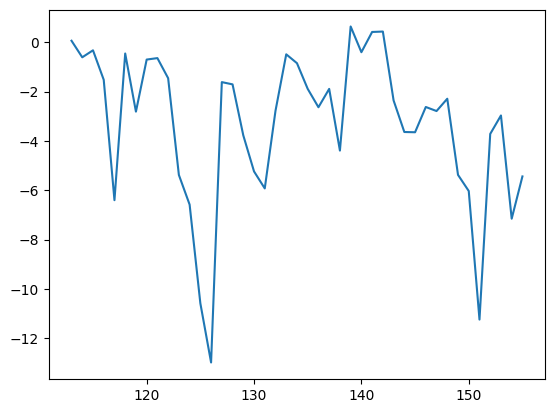

In [278]:
plt.plot(df_trading_strategy_2019_weekly['Predicted_Return']/df_trading_strategy_2019_weekly['Vol_2W_lag_7'])

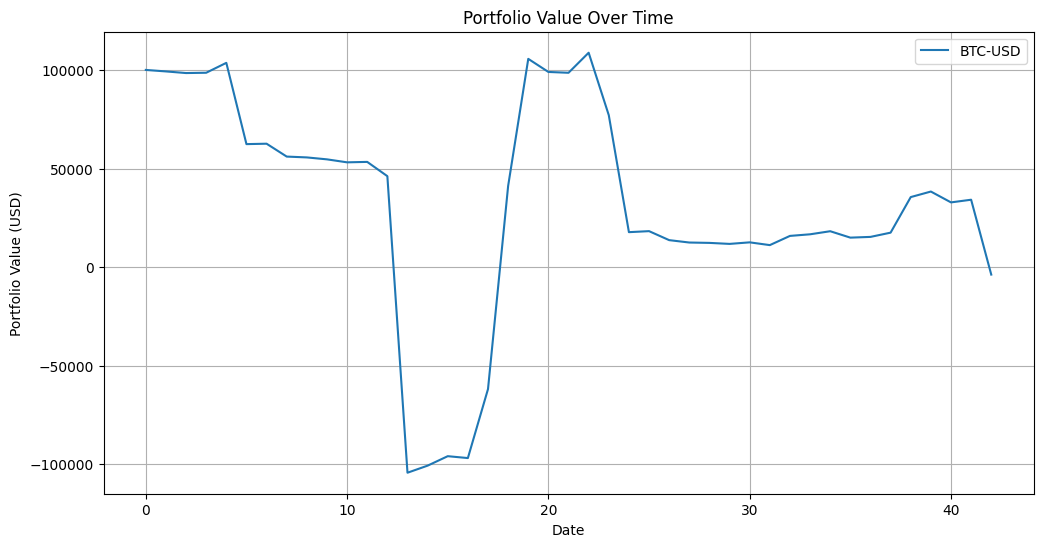

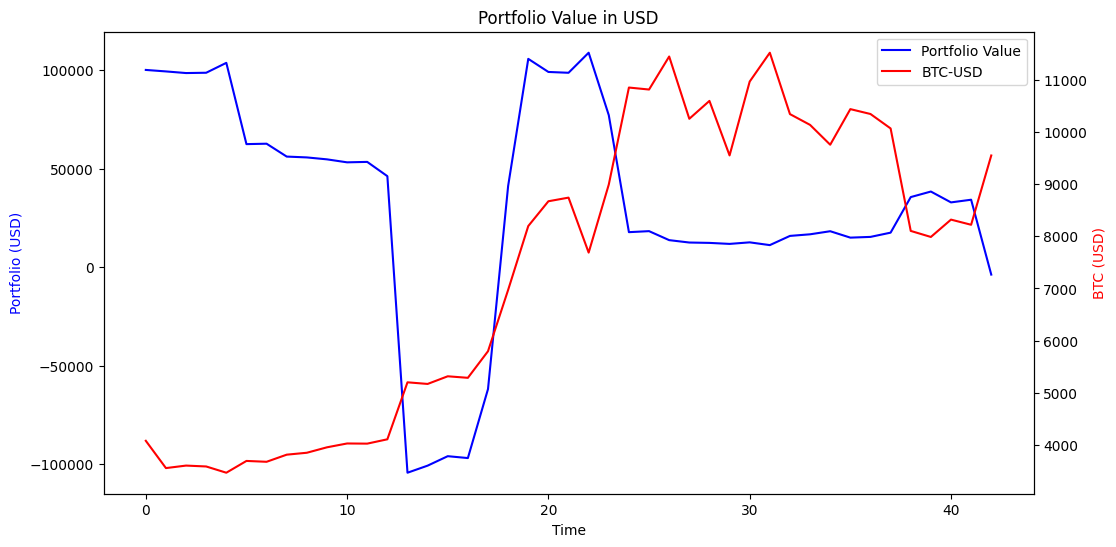

In [281]:
#df_trading_strategy_2019_weekly = df_trading_strategy_2019_weekly[df_trading_strategy_2019_weekly['Date']>=pd.to_datetime('2019-01-01')]

# Define the initial portfolio balance in USD
initial_balance = 100000
total_portfolio_value = 100000

# Initialize portfolio variables
portfolio_balance = initial_balance
btc_holdings = 0

# Create lists to store the portfolio values and BTC holdings over time
portfolio_values_1 = []
btc_holdings_values_1 = []
weights_1 = []

# Iterate through the 'filtered_df_vader' DataFrame
for index, row in df_trading_strategy_2019_weekly.iterrows():
    weight = row['x']
    btc_price = row['Price']  # Get the BTC price for the current date

    # Calculate the amount to invest in BTC based on scaled sentiment
    investment_in_btc = weight * total_portfolio_value - btc_holdings * btc_price

    # Update BTC holdings and portfolio balance
    btc_holdings += investment_in_btc / btc_price
    portfolio_balance -= investment_in_btc

    # Calculate the total portfolio value
    total_portfolio_value = portfolio_balance + (btc_holdings * btc_price)

    # Append values to the lists
    portfolio_values_1.append(total_portfolio_value)
    btc_holdings_values_1.append(btc_holdings)
    weights_1.append(weight)
    
import matplotlib.pyplot as plt

# Plot the portfolio value in USD
plt.figure(figsize=(12, 6))

plt.plot(df_trading_strategy_2019_weekly.index, portfolio_values_1, label='BTC-USD')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()


# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first curve on the first axis
ax1.plot(df_trading_strategy_2019_weekly.index, portfolio_values_1, 'b', label='Portfolio Value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio (USD)', color='b')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second curve on the second axis
ax2.plot(df_trading_strategy_2019_weekly.index, df_trading_strategy_2019_weekly['Price'], 'r', label='BTC-USD')
ax2.set_ylabel('BTC (USD)', color='r')
# Add labels and title
plt.title('Portfolio Value in USD')

# Add a legend for both curves
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

### Trying a for Loop

In [284]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.losses import Huber

# Functions for data processing
def preprocess_data(df):
    features = df.iloc[:, 2:]  # Assuming 'Return' is the second column
    target = df['Weekly_Return']

    # Feature scaling
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler_features.fit_transform(features)

    # Target scaling
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

    return scaled_features, scaled_target, scaler_features, scaler_target

def train_model(X_train, y_train):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    huber_loss = Huber(delta=1.0)
    model.compile(optimizer='nadam', loss=huber_loss)

    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)
    
    return model

# Functions to get data
def get_data_up_to_current_week(df, current_week_start_date):
    return df[df['Date'] < current_week_start_date]

def get_next_week_data(df, current_week_start_date):
    next_week_start_date = current_week_start_date + pd.Timedelta(weeks=1)
    next_week_end_date = next_week_start_date + pd.Timedelta(weeks=1)
    return df[(df['Date'] >= next_week_start_date) & (df['Date'] < next_week_end_date)]


# Example: Comparing predictions with actual returns of 2019


In [293]:
# Prepare your initial dataset (2017 and 2018)
df_analysis_weekly['Date'] = pd.to_datetime(df_analysis_weekly['Date'])
initial_data = df_analysis_weekly[df_analysis_weekly['Date'] < '2019-01-06']
X, y, scaler_features, scaler_target = preprocess_data(initial_data)
X = X.reshape((X.shape[0], X.shape[1], 1))
model = train_model(X, y)

# Rolling training and prediction for 2019
start_date_2019 = pd.to_datetime('2019-01-06')
end_date_2019 = pd.to_datetime('2019-10-27')
current_week_start_date = start_date_2019
predictions = []

while current_week_start_date <= end_date_2019:
    updated_data = get_data_up_to_current_week(df_analysis_weekly, current_week_start_date)
    next_week_data = get_next_week_data(df_analysis_weekly, current_week_start_date)

    # Preprocess the updated data
    X_updated, y_updated, _, _ = preprocess_data(updated_data)
    X_updated = X_updated.reshape((X_updated.shape[0], X_updated.shape[1], 1))
    
    # Update the model with new data (consider fine-tuning instead of retraining from scratch)
    model.fit(X_updated, y_updated, epochs=100, batch_size=64, verbose=0)  # Reduced number of epochs

    # Predict with next_week_data
    if not next_week_data.empty:
        next_week_features = next_week_data.iloc[:, 2:]  # Assuming 'Return' is the second column
        next_week_features = scaler_features.transform(next_week_features)
        next_week_features = next_week_features.reshape((next_week_features.shape[0], next_week_features.shape[1], 1))
        prediction = model.predict(next_week_features)
        prediction_rescaled = scaler_target.inverse_transform(prediction)
        predictions.extend(prediction_rescaled.flatten())

    # Move to the next week
    current_week_start_date += pd.Timedelta(weeks=1)

# Performance evaluation
# ... [your performance evaluation code] ...

# Performance evaluation (you can implement this part based on your criteria)

/Users/mehdimouden/Desktop/EPFL/IF/MA3/Fin Machine Learning/BTC NLP/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1150
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149 
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 
Epoch 16/100
4/4 ━━━

In [294]:
print(len(predictions))

43


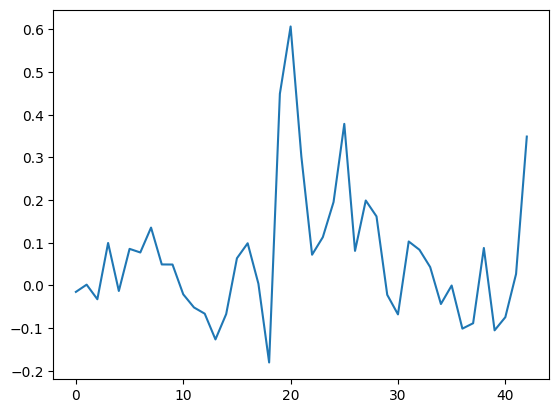

In [295]:
plt.plot(predictions)

In [291]:
df_trading_strategy_2019_weekly.head(50)

,Date,Weekly_Return,Weekly_Return_lag_7,Weekly_Return_lag_14,Weekly_Return_lag_21,Weekly_Return_lag_28,Weekly_Return_lag_35,Price_lag_7,Price_lag_8,Price_lag_9,...,Weekly_Volume_Change_lag_3,Weekly_Volume_Change_lag_4,Volume_lag_7,Volume_lag_8,Volume_lag_9,Volume_lag_10,Volume_lag_11,Predicted_Return,x,Price
0,2019-01-06,0.053063,-0.033831,0.206511,-0.105352,-0.135786,0.031883,3865.952637,3820.408691,3923.918701,...,-0.192374,-0.967807,4.770579e+09,4.991656e+09,5.631554e+09,5.130222e+09,5.326548e+09,0.011347,0.058793,4076.632568
1,2019-01-13,-0.137492,0.053063,-0.033831,0.206511,-0.105352,-0.135786,4076.632568,3845.194580,3857.717529,...,0.165236,-0.192374,5.597027e+09,5.137610e+09,4.847965e+09,4.530215e+09,5.244857e+09,-0.087490,-0.612763,3552.953125
2,2019-01-20,0.013436,-0.137492,0.053063,-0.033831,0.206511,-0.105352,3552.953125,3661.301025,3687.365479,...,-0.230203,0.165236,4.681302e+09,4.778171e+09,5.538713e+09,6.874144e+09,5.115905e+09,-0.042017,-0.329163,3601.013672
3,2019-01-27,-0.004745,0.013436,-0.137492,0.053063,-0.033831,0.206511,3601.013672,3728.568359,3657.839355,...,0.143541,-0.230203,5.582490e+09,5.955691e+09,5.002962e+09,5.464420e+09,5.394457e+09,-0.177594,-1.524593,3583.965820
4,2019-02-03,-0.034042,-0.004745,0.013436,-0.137492,0.053063,-0.033831,3583.965820,3602.460449,3599.765869,...,0.169456,0.143541,5.570753e+09,5.098183e+09,5.265848e+09,5.262869e+09,5.433756e+09,-0.409403,-6.405023,3464.013428
5,2019-02-10,0.063250,-0.034042,-0.004745,0.013436,-0.137492,0.053063,3464.013428,3521.060791,3487.945312,...,75.592129,0.169456,5.043938e+09,5.071624e+09,5.422927e+09,5.831198e+09,5.955113e+09,-0.019908,-0.458684,3690.188232
6,2019-02-17,-0.004441,0.063250,-0.034042,-0.004745,0.013436,-0.137492,3690.188232,3671.203613,3666.780273,...,0.502814,75.592129,6.282257e+09,6.158834e+09,7.735623e+09,5.004963e+09,5.482196e+09,-0.247252,-2.815553,3673.836182
7,2019-02-24,0.036505,-0.004441,0.063250,-0.034042,-0.004745,0.013436,3673.836182,3629.787598,3620.810791,...,-0.991203,0.502814,7.039513e+09,5.934744e+09,6.091952e+09,6.271044e+09,6.438904e+09,-0.056158,-0.704630,3810.427490
8,2019-03-03,0.009598,0.036505,-0.004441,0.063250,-0.034042,-0.004745,3810.427490,4142.526855,4005.526611,...,0.042403,-0.991203,1.079423e+10,8.922258e+09,7.826525e+09,7.775128e+09,8.693374e+09,-0.073757,-0.645530,3847.175781
9,2019-03-10,0.026781,0.009598,0.036505,-0.004441,0.063250,-0.034042,3847.175781,3864.415039,3859.583740,...,-0.022034,0.042403,7.253558e+09,7.578786e+09,7.661248e+09,8.399768e+09,8.301310e+09,-0.167412,-1.459916,3951.599854


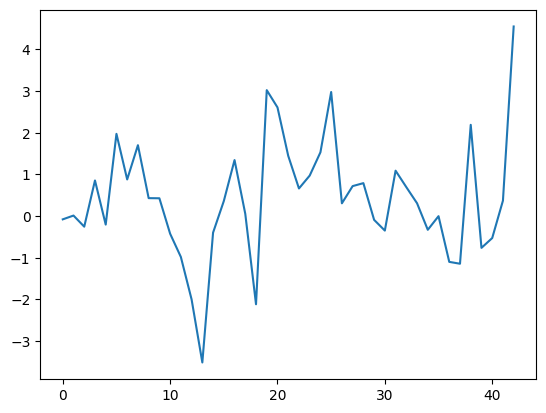

In [299]:
df_trading_strategy_2019_weekly = df_analysis_2019_weekly.copy()
df_trading_strategy_2019_weekly['Predicted_Return'] = predictions
Sharpe_Ratio_RM = 3
UpBound = 1
DownBound = -1
df_trading_strategy_2019_weekly['x'] = df_trading_strategy_2019_weekly['Predicted_Return'] / df_trading_strategy_2019_weekly['Vol_2W_lag_7'] / Sharpe_Ratio_RM
# Merge based on the 'Date' column
df_trading_strategy_2019_weekly = df_trading_strategy_2019_weekly.merge(btc_2[['Date', 'Price']], on='Date', how='left')
df_trading_strategy_2019_weekly.head()
plt.plot(df_trading_strategy_2019_weekly['Predicted_Return'] / df_trading_strategy_2019_weekly['Vol_2W_lag_7'])

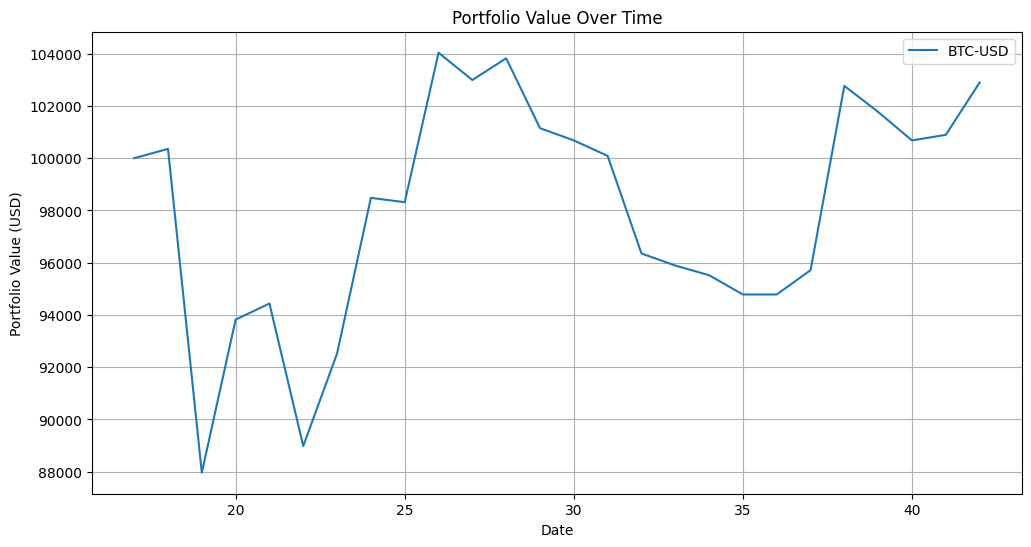

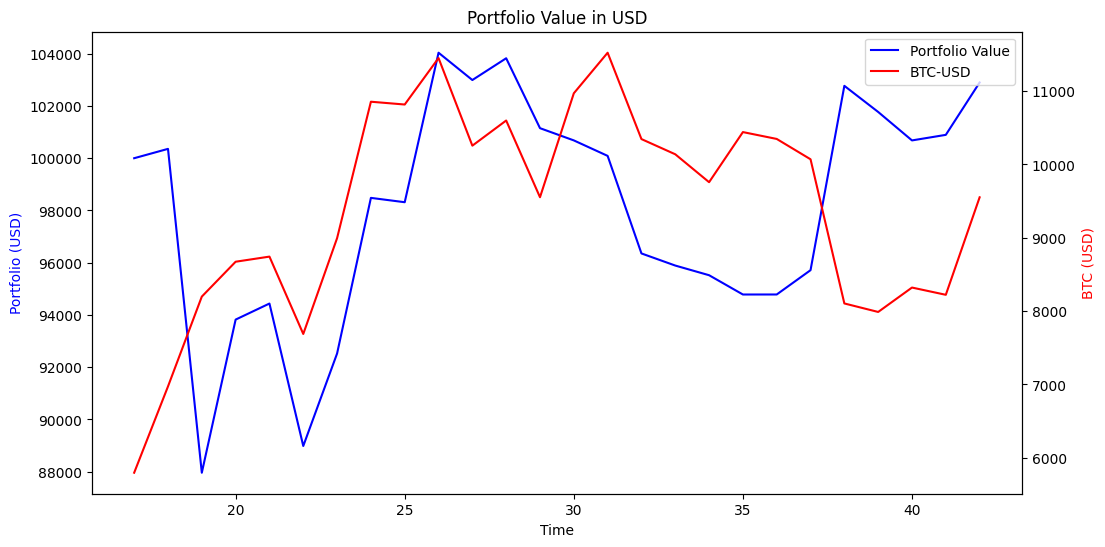

In [301]:
df_trading_strategy_2019_weekly = df_trading_strategy_2019_weekly[df_trading_strategy_2019_weekly['Date']>=pd.to_datetime('2019-05-01')]

# Define the initial portfolio balance in USD
initial_balance = 100000
total_portfolio_value = 100000

# Initialize portfolio variables
portfolio_balance = initial_balance
btc_holdings = 0

# Create lists to store the portfolio values and BTC holdings over time
portfolio_values_1 = []
btc_holdings_values_1 = []
weights_1 = []

# Iterate through the 'filtered_df_vader' DataFrame
for index, row in df_trading_strategy_2019_weekly.iterrows():
    weight = row['x']
    btc_price = row['Price']  # Get the BTC price for the current date

    # Calculate the amount to invest in BTC based on scaled sentiment
    investment_in_btc = weight * total_portfolio_value - btc_holdings * btc_price

    # Update BTC holdings and portfolio balance
    btc_holdings += investment_in_btc / btc_price
    portfolio_balance -= investment_in_btc

    # Calculate the total portfolio value
    total_portfolio_value = portfolio_balance + (btc_holdings * btc_price)

    # Append values to the lists
    portfolio_values_1.append(total_portfolio_value)
    btc_holdings_values_1.append(btc_holdings)
    weights_1.append(weight)
    
import matplotlib.pyplot as plt

# Plot the portfolio value in USD
plt.figure(figsize=(12, 6))

plt.plot(df_trading_strategy_2019_weekly.index, portfolio_values_1, label='BTC-USD')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()


# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first curve on the first axis
ax1.plot(df_trading_strategy_2019_weekly.index, portfolio_values_1, 'b', label='Portfolio Value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio (USD)', color='b')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second curve on the second axis
ax2.plot(df_trading_strategy_2019_weekly.index, df_trading_strategy_2019_weekly['Price'], 'r', label='BTC-USD')
ax2.set_ylabel('BTC (USD)', color='r')
# Add labels and title
plt.title('Portfolio Value in USD')

# Add a legend for both curves
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

In [304]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Functions for data processing
def preprocess_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.iloc[:, 1:])  # Exclude 'Date'

    X = scaled_data[:, 1:]  # All features except 'Return'
    y = scaled_data[:, 0]  # 'Return' is the target
    return X, y, scaler

def train_model(X_train, y_train):
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Reshape for LSTM

    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)  # Reduced number of epochs for demonstration

    return model

# Functions to get data
def get_data_up_to_current_week(df, current_week_start_date):
    return df[df['Date'] < current_week_start_date]

def get_next_week_data(df, current_week_start_date):
    next_week_start_date = current_week_start_date + pd.Timedelta(weeks=1)
    next_week_end_date = next_week_start_date + pd.Timedelta(weeks=1)
    return df[(df['Date'] >= next_week_start_date) & (df['Date'] < next_week_end_date)]




In [ ]:
# Prepare your initial dataset (2017 and 2018)
df_analysis_weekly['Date'] = pd.to_datetime(df_analysis_weekly['Date'])
initial_data = df_analysis_weekly[df_analysis_weekly['Date'] < '2019-01-01']
X, y, scaler = preprocess_data(initial_data)
model = train_model(X, y)

# Rolling training and prediction for 2019
start_date_2019 = pd.to_datetime('2019-01-01')
end_date_2019 = pd.to_datetime('2019-12-31')
current_week_start_date = start_date_2019
predictions = []

while current_week_start_date <= end_date_2019:
    updated_data = get_data_up_to_current_week(df_analysis_weekly, current_week_start_date)
    next_week_data = get_next_week_data(df_analysis_weekly, current_week_start_date)

    # Preprocess the updated data
    X_updated, y_updated, _ = preprocess_data(updated_data)
    model = train_model(X_updated, y_updated)

    # Predict with next_week_data
    if not next_week_data.empty:
        next_week_features = next_week_data.iloc[:, 2:]
        next_week_features = scaler.transform(next_week_features)
        next_week_features = next_week_features.reshape((next_week_features.shape[0], 1, next_week_features.shape[1]))
        prediction = model.predict(next_week_features)
        prediction_rescaled = scaler.inverse_transform(np.concatenate((prediction, np.zeros((len(prediction), X.shape[1]))), axis=1))[:, 0]
        predictions.extend(prediction_rescaled)

    # Move to the next week
    current_week_start_date += pd.Timedelta(weeks=1)

# Performance evaluation
# ... [your performance evaluation code] ...

In [306]:
df_analysis_weekly.head()

,Date,Weekly_Return,Weekly_Return_lag_7,Weekly_Return_lag_14,Weekly_Return_lag_21,Weekly_Return_lag_28,Weekly_Return_lag_35,Price_lag_7,Price_lag_8,Price_lag_9,...,Weekly_Volume_lag_1,Weekly_Volume_Change_lag_1,Weekly_Volume_Change_lag_2,Weekly_Volume_Change_lag_3,Weekly_Volume_Change_lag_4,Volume_lag_7,Volume_lag_8,Volume_lag_9,Volume_lag_10,Volume_lag_11
5,2016-12-11,-0.005365,0.055578,0.001379,0.040471,-0.013429,0.013667,773.872009,771.155029,777.943970,...,37.0,0.321429,-0.096774,0.240000,0.388889,60557900.0,69547296.0,127605000.0,80461904.0,84070800.0
6,2016-12-18,0.026663,-0.005365,0.055578,0.001379,0.040471,-0.013429,769.731018,774.650024,772.794006,...,36.0,-0.027027,0.321429,-0.096774,0.240000,57313400.0,53843100.0,68705296.0,80111904.0,96426096.0
7,2016-12-25,0.125441,0.026663,-0.005365,0.055578,0.001379,0.040471,790.530029,790.828979,784.906982,...,3771.0,103.750000,-0.027027,0.321429,-0.096774,60524400.0,78989800.0,83608200.0,81580096.0,75979000.0
8,2017-01-01,0.107934,0.125441,0.026663,-0.005365,0.055578,0.001379,896.182983,898.822021,921.984009,...,2921.0,-0.225404,103.750000,-0.027027,0.321429,143664992.0,137727008.0,275564000.0,200027008.0,155576000.0
9,2017-01-08,-0.091318,0.107934,0.125441,0.026663,-0.005365,0.055578,998.325012,963.742981,961.237976,...,72.0,-0.975351,-0.225404,103.750000,-0.027027,147775008.0,99135104.0,187474000.0,199320000.0,236630000.0


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Function to preprocess data
def preprocess_data(df, feature_cols, target_col):
    # Separate scaler for features
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler_features.fit_transform(df[feature_cols])

    # Separate scaler for target
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    scaled_target = scaler_target.fit_transform(df[target_col].values.reshape(-1, 1))

    return scaled_features, scaled_target, scaler_features, scaler_target

def train_model(X_train, y_train):
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    return model

# Identify feature and target columns
feature_columns = df_analysis_weekly.columns.drop(['Date', 'Weekly_Return'])
target_column = 'Weekly_Return'

# Prepare your initial dataset (2017 and 2018)
initial_data = df_analysis_weekly[df_analysis_weekly['Date'] < '2019-01-01']
X, y, scaler_features, scaler_target = preprocess_data(initial_data, feature_columns, target_column)
model = train_model(X, y)

# Rolling training and prediction for 2019
start_date_2019 = pd.to_datetime('2019-01-06')
end_date_2019 = pd.to_datetime('2019-10-27')
current_week_start_date = start_date_2019
predictions = []

while current_week_start_date <= end_date_2019:
    updated_data = get_data_up_to_current_week(df_analysis_weekly, current_week_start_date)
    next_week_data = get_next_week_data(df_analysis_weekly, current_week_start_date)

    # Preprocess the updated data
    X_updated, y_updated, _, _ = preprocess_data(updated_data, feature_columns, target_column)
    model = train_model(X_updated, y_updated)

    # Predict with next_week_data
    if not next_week_data.empty:
        next_week_features = scaler_features.transform(next_week_data[feature_columns])
        next_week_features = next_week_features.reshape((next_week_features.shape[0], 1, next_week_features.shape[1]))
        prediction = model.predict(next_week_features)
        prediction_rescaled = scaler_target.inverse_transform(prediction)
        predictions.extend(prediction_rescaled.flatten())

    # Move to the next week
    current_week_start_date += pd.Timedelta(weeks=1)

# Performance evaluation
# ... [your performance evaluation code] ...


In [308]:
print(predictions)

[0.040336203, -0.0052899383, 0.13315935, 0.07239496, 0.0057763937, -0.06835802, 0.01210637, 0.046784632, 0.034928646, 0.047409907, -0.017545568, -0.03485662, -0.02645031, 0.027879706, 0.03830235, 0.09608797, 0.057806708, -0.004008161, 0.030331409, 0.04279446, 0.17021266, 0.117042854, 0.072779916, -0.05935172, -0.07515591, 0.09838611, 0.029063867, 0.12461787, 0.04624211, -0.06135772, 0.02498005, -0.0405445, -0.06641819, -0.062901534, -0.033332746, 0.013198803, -0.053812686, -0.05059839, -0.057867218, -0.023453478, -0.071571335, 0.016452765, 0.15821588]


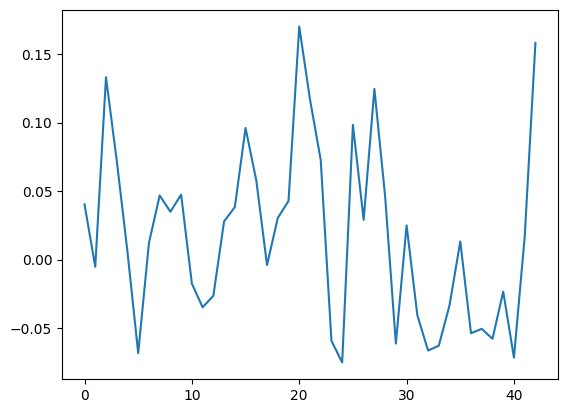

In [309]:
plt.plot(predictions)

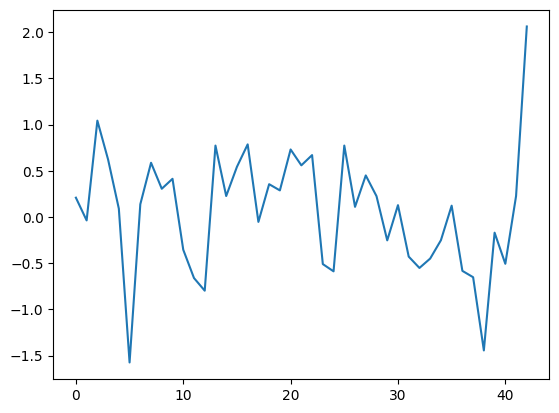

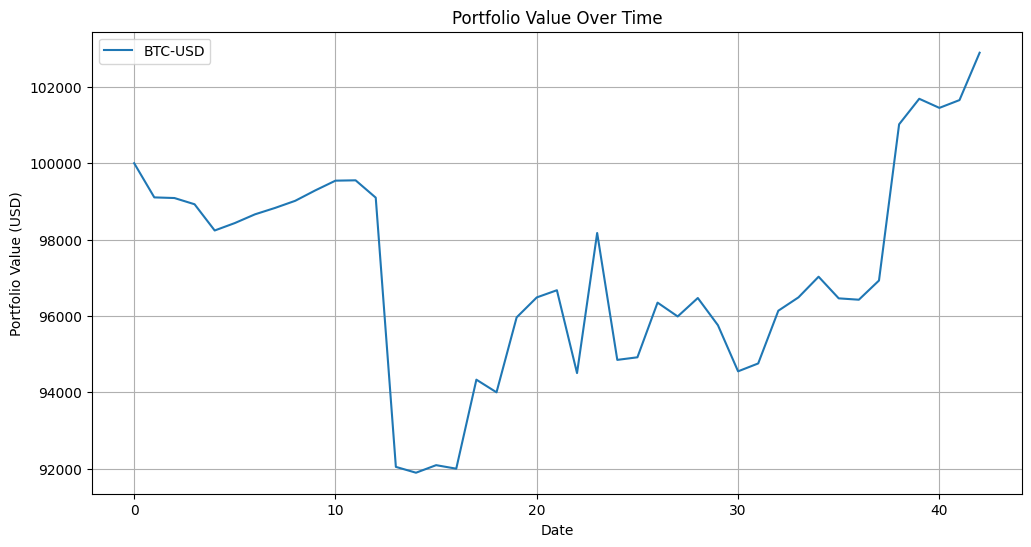

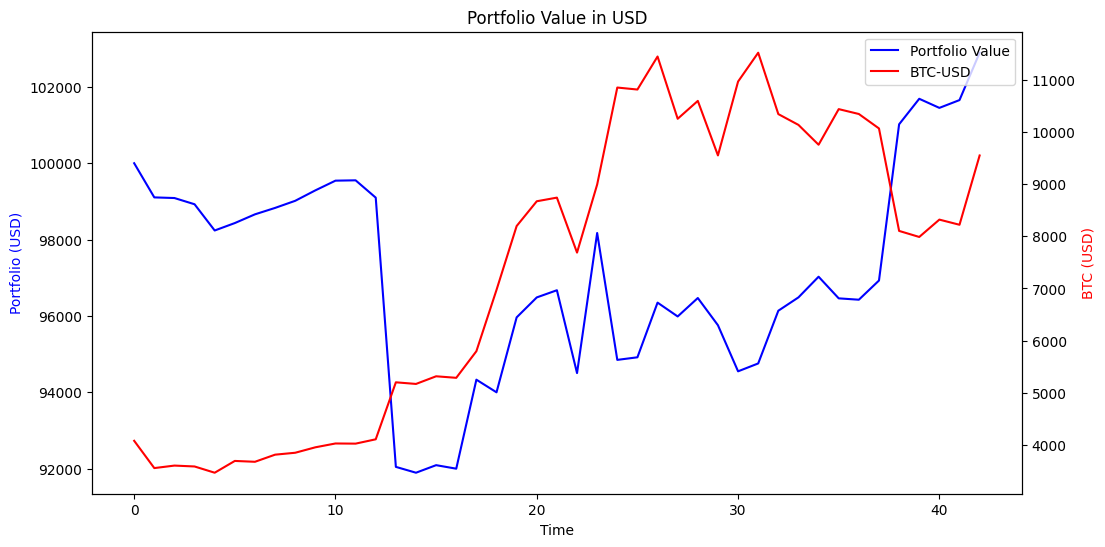

In [310]:
df_trading_strategy_2019_weekly = df_analysis_2019_weekly.copy()
df_trading_strategy_2019_weekly['Predicted_Return'] = predictions
Sharpe_Ratio_RM = 3
UpBound = 1
DownBound = -1
df_trading_strategy_2019_weekly['x'] = df_trading_strategy_2019_weekly['Predicted_Return'] / df_trading_strategy_2019_weekly['Vol_2W_lag_7'] / Sharpe_Ratio_RM
# Merge based on the 'Date' column
df_trading_strategy_2019_weekly = df_trading_strategy_2019_weekly.merge(btc_2[['Date', 'Price']], on='Date', how='left')
df_trading_strategy_2019_weekly.head()
plt.plot(df_trading_strategy_2019_weekly['Predicted_Return'] / df_trading_strategy_2019_weekly['Vol_2W_lag_7'])
#df_trading_strategy_2019_weekly = df_trading_strategy_2019_weekly[
#df_trading_strategy_2019_weekly['Date'] >= pd.to_datetime('2019-0-01')]



# Define the initial portfolio balance in USD
initial_balance = 100000
total_portfolio_value = 100000

# Initialize portfolio variables
portfolio_balance = initial_balance
btc_holdings = 0

# Create lists to store the portfolio values and BTC holdings over time
portfolio_values_1 = []
btc_holdings_values_1 = []
weights_1 = []

# Iterate through the 'filtered_df_vader' DataFrame
for index, row in df_trading_strategy_2019_weekly.iterrows():
    weight = row['x']
    btc_price = row['Price']  # Get the BTC price for the current date

    # Calculate the amount to invest in BTC based on scaled sentiment
    investment_in_btc = weight * total_portfolio_value - btc_holdings * btc_price

    # Update BTC holdings and portfolio balance
    btc_holdings += investment_in_btc / btc_price
    portfolio_balance -= investment_in_btc

    # Calculate the total portfolio value
    total_portfolio_value = portfolio_balance + (btc_holdings * btc_price)

    # Append values to the lists
    portfolio_values_1.append(total_portfolio_value)
    btc_holdings_values_1.append(btc_holdings)
    weights_1.append(weight)

import matplotlib.pyplot as plt

# Plot the portfolio value in USD
plt.figure(figsize=(12, 6))

plt.plot(df_trading_strategy_2019_weekly.index, portfolio_values_1, label='BTC-USD')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first curve on the first axis
ax1.plot(df_trading_strategy_2019_weekly.index, portfolio_values_1, 'b', label='Portfolio Value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio (USD)', color='b')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second curve on the second axis
ax2.plot(df_trading_strategy_2019_weekly.index, df_trading_strategy_2019_weekly['Price'], 'r', label='BTC-USD')
ax2.set_ylabel('BTC (USD)', color='r')
# Add labels and title
plt.title('Portfolio Value in USD')

# Add a legend for both curves
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Function to preprocess data
def preprocess_data(df, feature_cols, target_col):
    # Separate scaler for features
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler_features.fit_transform(df[feature_cols])

    # Separate scaler for target
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    scaled_target = scaler_target.fit_transform(df[target_col].values.reshape(-1, 1))

    return scaled_features, scaled_target, scaler_features, scaler_target

def train_model(X_train, y_train):
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    return model

# Identify feature and target columns
feature_columns = df_analysis_weekly.columns.drop(['Date', 'Weekly_Return'])
target_column = 'Weekly_Return'

# Prepare your initial dataset (2017 and 2018)
initial_data = df_analysis_weekly[df_analysis_weekly['Date'] < '2018-01-01']
X, y, scaler_features, scaler_target = preprocess_data(initial_data, feature_columns, target_column)
model = train_model(X, y)

# Rolling training and prediction for 2019
start_date_2019 = pd.to_datetime('2018-01-07')
end_date_2019 = pd.to_datetime('2019-10-27')
current_week_start_date = start_date_2019
predictions_18_19 = []

while current_week_start_date <= end_date_2019:
    updated_data = get_data_up_to_current_week(df_analysis_weekly, current_week_start_date)
    next_week_data = get_next_week_data(df_analysis_weekly, current_week_start_date)

    # Preprocess the updated data
    X_updated, y_updated, _, _ = preprocess_data(updated_data, feature_columns, target_column)
    model = train_model(X_updated, y_updated)

    # Predict with next_week_data
    if not next_week_data.empty:
        next_week_features = scaler_features.transform(next_week_data[feature_columns])
        next_week_features = next_week_features.reshape((next_week_features.shape[0], 1, next_week_features.shape[1]))
        prediction = model.predict(next_week_features)
        prediction_rescaled = scaler_target.inverse_transform(prediction)
        predictions_18_19.extend(prediction_rescaled.flatten())

    # Move to the next week
    current_week_start_date += pd.Timedelta(weeks=1)

# Performance evaluation
# ... [your performance evaluation code] ...

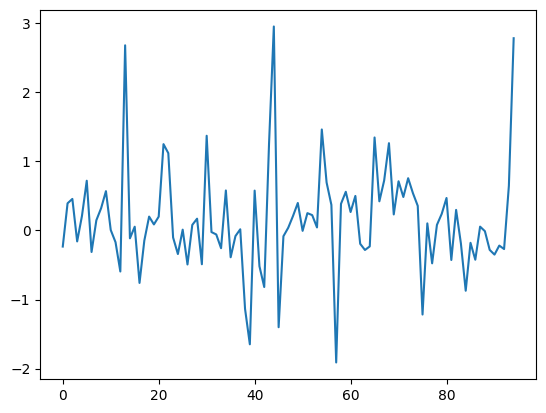

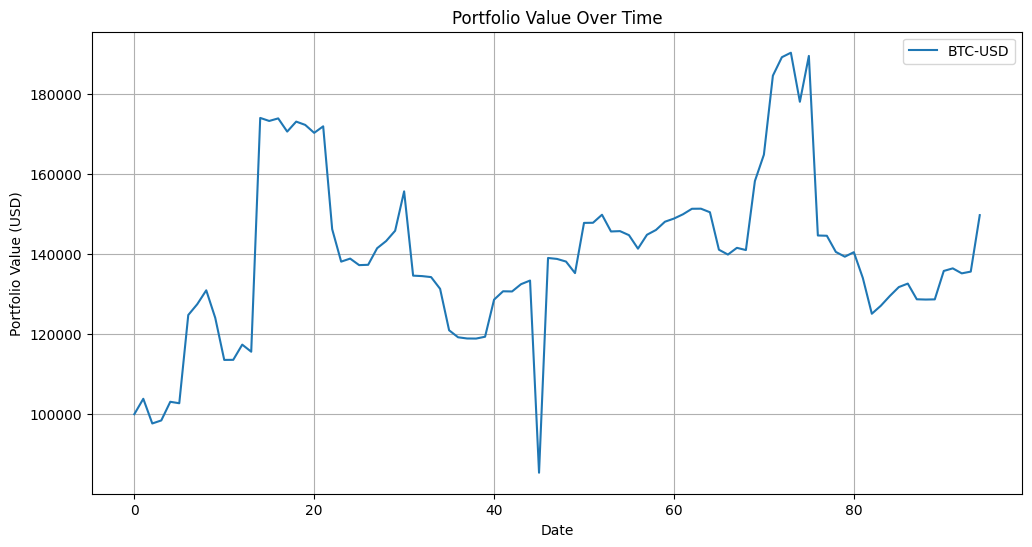

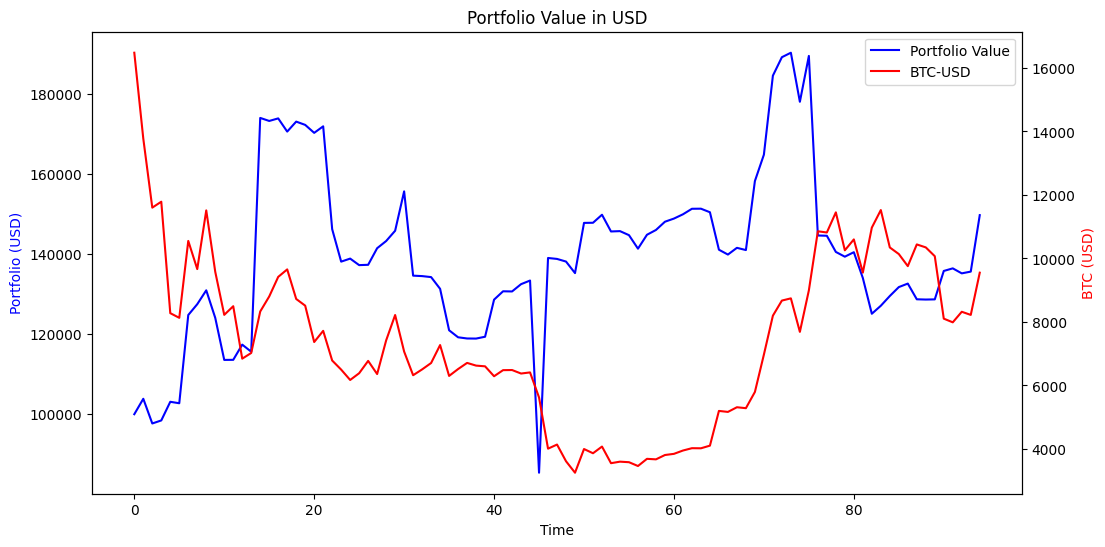

In [317]:
#df_analysis_2017_2018 = df_analysis[(df_analysis['Date']<pd.to_datetime('2019-01-01'))&(df_analysis['Date']>= pd.to_datetime('2017-01-01'))]
df_analysis_2018_2019_weekly = df_analysis_weekly[
    (df_analysis_weekly['Date'] < pd.to_datetime('2019-11-01')) & (df_analysis_weekly['Date'] >= pd.to_datetime('2018-01-01'))]
df_trading_strategy_2019_weekly = df_analysis_2018_2019_weekly.copy()
df_trading_strategy_2019_weekly['Predicted_Return'] = predictions_18_19
Sharpe_Ratio_RM = 1
UpBound = 1
DownBound = -1
df_trading_strategy_2019_weekly['x'] = df_trading_strategy_2019_weekly['Predicted_Return'] / df_trading_strategy_2019_weekly['Vol_2W_lag_7'] / Sharpe_Ratio_RM
# Merge based on the 'Date' column
df_trading_strategy_2019_weekly = df_trading_strategy_2019_weekly.merge(btc_2[['Date', 'Price']], on='Date', how='left')
df_trading_strategy_2019_weekly.head()
plt.plot(df_trading_strategy_2019_weekly['Predicted_Return'] / df_trading_strategy_2019_weekly['Vol_2W_lag_7'])
#df_trading_strategy_2019_weekly = df_trading_strategy_2019_weekly[
#df_trading_strategy_2019_weekly['Date'] >= pd.to_datetime('2019-0-01')]



# Define the initial portfolio balance in USD
initial_balance = 100000
total_portfolio_value = 100000

# Initialize portfolio variables
portfolio_balance = initial_balance
btc_holdings = 0

# Create lists to store the portfolio values and BTC holdings over time
portfolio_values_1 = []
btc_holdings_values_1 = []
weights_1 = []

# Iterate through the 'filtered_df_vader' DataFrame
for index, row in df_trading_strategy_2019_weekly.iterrows():
    weight = row['x']
    btc_price = row['Price']  # Get the BTC price for the current date

    # Calculate the amount to invest in BTC based on scaled sentiment
    investment_in_btc = weight * total_portfolio_value - btc_holdings * btc_price

    # Update BTC holdings and portfolio balance
    btc_holdings += investment_in_btc / btc_price
    portfolio_balance -= investment_in_btc

    # Calculate the total portfolio value
    total_portfolio_value = portfolio_balance + (btc_holdings * btc_price)

    # Append values to the lists
    portfolio_values_1.append(total_portfolio_value)
    btc_holdings_values_1.append(btc_holdings)
    weights_1.append(weight)

import matplotlib.pyplot as plt

# Plot the portfolio value in USD
plt.figure(figsize=(12, 6))

plt.plot(df_trading_strategy_2019_weekly.index, portfolio_values_1, label='BTC-USD')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first curve on the first axis
ax1.plot(df_trading_strategy_2019_weekly.index, portfolio_values_1, 'b', label='Portfolio Value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio (USD)', color='b')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second curve on the second axis
ax2.plot(df_trading_strategy_2019_weekly.index, df_trading_strategy_2019_weekly['Price'], 'r', label='BTC-USD')
ax2.set_ylabel('BTC (USD)', color='r')
# Add labels and title
plt.title('Portfolio Value in USD')

# Add a legend for both curves
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

In [322]:
df_trading_strategy_2019_weekly.head()

,Date,Weekly_Return,Weekly_Return_lag_7,Weekly_Return_lag_14,Weekly_Return_lag_21,Weekly_Return_lag_28,Weekly_Return_lag_35,Price_lag_7,Price_lag_8,Price_lag_9,...,Weekly_Volume_Change_lag_3,Weekly_Volume_Change_lag_4,Volume_lag_7,Volume_lag_8,Volume_lag_9,Volume_lag_10,Volume_lag_11,Predicted_Return,x,Price
0,2018-01-07,0.151835,0.016424,-0.318079,0.213864,0.311105,0.193560,14156.400391,12952.200195,14656.200195,...,-0.988563,117.897196,1.213630e+10,1.445260e+10,1.302550e+10,1.233650e+10,1.248760e+10,-0.068731,-0.234692,16477.599609
1,2018-01-14,-0.179364,0.151835,0.016424,-0.318079,0.213864,0.311105,16477.599609,17527.000000,17429.500000,...,-0.103093,-0.988563,1.586600e+10,1.831460e+10,2.384090e+10,2.178320e+10,1.687190e+10,0.107713,0.390810,13772.000000
2,2018-01-21,-0.171624,-0.179364,0.151835,0.016424,-0.318079,0.213864,13772.000000,14360.200195,13980.599609,...,-0.348659,-0.103093,1.108410e+10,1.276360e+10,1.206570e+10,1.653410e+10,1.850080e+10,0.103901,0.454197,11600.099609
3,2018-01-28,0.015924,-0.171624,-0.179364,0.151835,0.016424,-0.318079,11600.099609,12899.200195,11607.400391,...,0.094118,-0.348659,9.935180e+09,1.180170e+10,1.074040e+10,1.502040e+10,1.883060e+10,-0.046229,-0.160077,11786.299805
4,2018-02-04,-0.353456,0.015924,-0.171624,-0.179364,0.151835,0.016424,11786.299805,11440.700195,11171.400391,...,0.177419,0.094118,8.350360e+09,7.583270e+09,9.746200e+09,8.873170e+09,9.940990e+09,0.053029,0.207887,8277.009766


Mean Squared Error on Test Set for Model 1: 0.02071133296861123


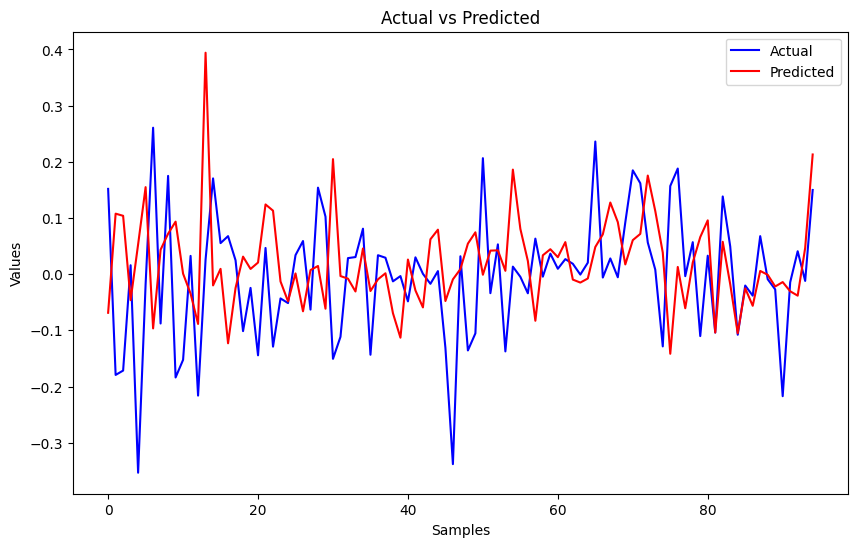

In [320]:
# Calculate MSE
mse = mean_squared_error(df_trading_strategy_2019_weekly['Weekly_Return'], df_trading_strategy_2019_weekly['Predicted_Return'])
print(f'Mean Squared Error on Test Set for Model 1: {mse}')
# Line plot
plt.figure(figsize=(10, 6))
plt.plot(df_trading_strategy_2019_weekly['Weekly_Return'], label='Actual', color='blue')
plt.plot(df_trading_strategy_2019_weekly['Predicted_Return'], label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()

In [326]:
#mse = mean_squared_error(df_trading_strategy_2019_weekly['Weekly_Return'], df_trading_strategy_2019_weekly['Predicted_Return'])
print((df_trading_strategy_2019_weekly['Price'][92]-df_trading_strategy_2019_weekly['Price'][0])/df_trading_strategy_2019_weekly['Price'][0])

print((portfolio_values_1[-1]-portfolio_values_1[0])/portfolio_values_1[0])

-0.49501104186068895
0.49692664690150123


In [331]:
np.std(np.log(portfolio_values_1.diff()))

AttributeError: 'list' object has no attribute 'diff'

In [332]:
print(type(portfolio_values_1))

<class 'list'>


In [344]:
# Convert the list to a pandas DataFrame
df = pd.DataFrame(portfolio_values_1, columns=['Price'])

# Calculate returns as percentage change
df['Returns'] = np.log(df['Price']).diff()
df['BTC Returns'] = np.log(df_trading_strategy_2019_weekly['Price']).diff()
# Calculate volatility (standard deviation of returns)
volatility = df['Returns'].std()
btc_volatility = df['BTC Returns'].std()

print("Volatility:", volatility*np.sqrt(52))
print("BTC Volatility:", btc_volatility*np.sqrt(52))
print("Mean return", (1+np.mean(df['Returns']))**52-1)
print("Mean return BTC", (1+np.mean(df['BTC Returns']))**52-1)
print("Sharpe Ratio", ((1+np.mean(df['Returns']))**52-1)/(volatility*np.sqrt(52)))
print("Sharpe Ratio", ((1+np.mean(df['BTC Returns']))**52-1)/(btc_volatility*np.sqrt(52)))
print()

Volatility: 0.7005612444817164
BTC Volatility: 0.8127353374325312
Mean return 0.24943036872721214
Mean return BTC -0.26104865075186356
Sharpe Ratio 0.3560436302920863
Sharpe Ratio -0.32119761345252734


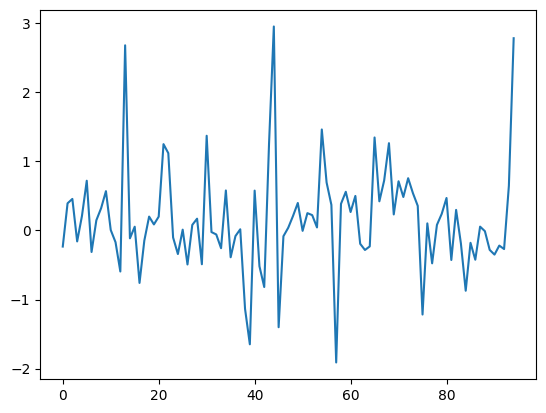

In [346]:
plt.plot(df_trading_strategy_2019_weekly['x'])

In [ ]:
print()